# Validation using bootstrapping over downloaded document corpus for 'debiaser' data product
#### Sagar Setru, September 21th, 2020

## Brief description using CoNVO framework

### Context

Some people are eager to get news from outside of their echo chamber. However, they do not know where to go outside of their echo chambers, and may also have some activation energy when it comes to seeking information from other sources. In the meantime, most newsfeeds only push you content that you agree with. You end up in an echo chamber, but may not have ever wanted to be in one in the first place.

### Need

A way to find news articles from different yet reliable media sources.

### Vision

Debiaser, a data product (maybe Chrome plug-in?) that will recommend news articles similar in topic to the one currently being read, but from several pre-curated and reliable news media organizations across the political spectrum, for example, following the "media bias chart" here https://www.adfontesmedia.com/ or the "media bias ratings" here: https://www.allsides.com/media-bias/media-bias-ratings. The app will determine the main topics of the text of a news article, and then show links to similar articles from other news organizations.

The product will generate topics for a given document via latent Dirichlet allocation (LDA) and then search news websites for the topic words generated.

Caveats: Many of these articles may be behind paywalls. News aggregators already basically do this. How different is this than just searching Google using the title of an article?

### Outcome

People who are motivated to engage in content outside of their echo chambers have a tool that enables them to quickly find news similar to what they are currently reading, but from a variety of news organizations.

### testing single document lda on these articles

In [1]:
# make sure I'm in the right environment (should be 'debiaser')
import os
print('Conda environment:')
print(os.environ['CONDA_DEFAULT_ENV'])

Conda environment:
debiaser


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import json

# NLP Packages
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# to break articles up into sentences
from nltk import tokenize

# for visualizing lda topics (as needed)
import pyLDAvis
import pyLDAvis.gensim

# import functions for text processing
from debiaser.text_processing_functions import process_all_articles
from debiaser.text_processing_functions import remove_stopwords
from debiaser.text_processing_functions import get_simple_corpus_dictionary_bow
from debiaser.text_processing_functions import load_stop_words_csv_to_list

# import functions for validation
from debiaser.debiaser_validation_function import get_jaccard_sim
from debiaser.debiaser_validation_function import get_lda_top_topic_words
from debiaser.debiaser_validation_function import get_single_topic_word_probs
from debiaser.debiaser_validation_function import count_word_frequencies
from debiaser.debiaser_validation_function import calculate_cosine_similarity


import pickle
print('DONE')

DONE


In [2]:
all_news_df = pd.read_csv('./all_the_news/all_news_df_processed.csv')
all_news_df.head()

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


index  index.1  id                                              title  \
0      0        0   1  Agent Cooper in Twin Peaks is the audience: on...   
1      1        1   2                                  AI, the humanity!   
2      2        2   3                                  The Viral Machine   
3      3        3   4  How Anker is beating Apple and Samsung at thei...   
4      4        4   5  Tour Black Panther’s reimagined homeland with ...   

                author        date  \
0   \nTasha Robinson\n  2017-05-31   
1       \nSam Byford\n  2017-05-30   
2  \nKaitlyn Tiffany\n  2017-05-25   
3       \nNick Statt\n  2017-05-22   
4       \nKwame Opam\n  2017-05-15   

                                             content    year  month  \
0        And never more so than in Showtime’s new...  2017.0    5.0   
1        AlphaGo’s victory isn’t a defeat for hum...  2017.0    5.0   
2        Super Deluxe built a weird internet empi...  2017.0    5.0   
3        Steven Yang quit his job at Google in th...  2017.0    5.0   
4        Ahead of Black Panther’s 2018 theatrical...  2017.0    5.0   

  publication  category  digital section  url  article_length  
0       Verge  Longform      1.0     NaN  NaN            2121  
1       Verge  Longform      1.0     NaN  NaN            1948  
2       Verge  Longform      1.0     NaN  NaN            3011  
3       Verge  Longform      1.0     NaN  NaN            3281  
4       Verge  Longform      1.0     NaN  NaN             239

In [4]:
# choose list of stop words

# choose whether 1k, 10k, 100k, or nltk
which_stop_words = '1k'
# which_stop_words = '10k'
# which_stop_words = '100k'
# which_stop_words = 'nltk'

stop_words_path = './stop_words_db/news-stopwords-master/'


if which_stop_words == '1k':
    
    # doing 1k words list
    stop_words_file_name = 'sw1k.csv'
    
    # make full file name
    stop_words_full_file_name = stop_words_path+stop_words_file_name
    
    # get list of stop words
    stop_words = load_stop_words_csv_to_list(stop_words_full_file_name)
    
elif which_stop_words == '10k':
    
    # doing 10k words list
    stop_words_file_name = 'sw10k.csv'

    # make full file name
    stop_words_full_file_name = stop_words_path+stop_words_file_name
    
    # get list of stop words
    stop_words = load_stop_words_csv_to_list(stop_words_full_file_name)

elif which_stop_words == '100k':
    
    # doing 100k
    stop_words_file_name = 'sw100k.csv'  
    
    # get full file name
    stop_words_full_file_name = stop_words_path+stop_words_file_name
    
    # get list of stop words
    stop_words = load_stop_words_csv_to_list(stop_words_full_file_name)


elif which_stop_words == 'nltk':
    # import from nltk
    from nltk.corpus import stopwords
    
    stop_words = stopwords.words('english')
    
else:
    print('Select proper variable name for "which_stop_words"')
    
# adding custom words
stop_words.append('said')
stop_words.append('youre')
stop_words.append('mph')
stop_words.append('inc')
stop_words.append('cov')
stop_words.append('jr')
stop_words.append('dr')
stop_words.append('ads')
stop_words.append('cookies')
stop_words.append('factset')

In [5]:
# get a random sampling of these articles for testing single document lda

# number of times to draw a bootstrap sampling
n_bootstrap_samples = 1000

# number of articles to draw per sampling
n_articles_per_sample = 50

In [10]:
%%time

# choose the number of LDA topics
# num_lda_topics = [1,2,3,4,5,6,7,8,9,10]
# num_lda_topics = [1,2,3,4,5]
num_lda_topics = [1]

# do by sentences
do_sentences = 1

# to show plots per  run
do_plot = 0

# to print output
do_print = 0

# to print progress of testing
do_progress_print = 1

# number of passes LDA does through corpus (hyperparameter)
n_passes = 6

# whether to use unique topic words or allow repeated words
do_unique_search_words = 1

# number of words to use in search
# (or number of top most often frequencies of words, e.g., use 5 highest word frequencies)
# (This could be more than 5 words if some words show up equally as often and among the msot often of all words)
n_search_words = 5

# dummy nlp variable, for now not in use because lemmatization not in use
nlp = []

# empty matrix for perplexity scores
perplexity_scores = np.zeros(( n_bootstrap_samples, n_articles_per_sample, len(num_lda_topics) ))

# empty matrix for coherence scores
coherence_scores = np.zeros(( n_bootstrap_samples, n_articles_per_sample, len(num_lda_topics) ))

# empty matrix for jaccard sim, set to nan in case any have 0 similarity
jaccard_sim_all = np.zeros(( n_bootstrap_samples, n_articles_per_sample, len(num_lda_topics) ))
jaccard_sim_all[:] = np.nan

# empty matrix for cosine sim, set to nan in case any have 0 similarity
cosine_sim_all = np.zeros(( n_bootstrap_samples, n_articles_per_sample, len(num_lda_topics) ))
cosine_sim_all[:] = np.nan

# empty matrix for length of most common words vec
number_most_common_words = np.zeros(( n_bootstrap_samples, n_articles_per_sample, len(num_lda_topics) ))

# empty matrix for number of sentences
n_sentences = np.zeros (( n_bootstrap_samples, n_articles_per_sample ))

# empty matrix for probability vs word in topic (doing for n = 1 topic only)
n_search_words_single_topic_analysis = 10
topic_word_probs = np.zeros(( n_bootstrap_samples, n_articles_per_sample, n_search_words_single_topic_analysis ))


# counter for bootstrap sampling
counter_nboot = -1

for i in range(n_bootstrap_samples):
    
    # draw random articles
    articles_df_random_subset = all_news_df.sample(n=n_articles_per_sample,replace=True)
    
    # get their content
    articles_content = articles_df_random_subset['content']
    
    counter_nboot += 1

    # counter for articles
    counter_article = -1
    
    for i in range(len(articles_content)):
        
        counter_article += 1
        
        for ind_num_topicss, num_topics in enumerate(num_lda_topics):

            # get the article text
            article_text = articles_content.iloc[i]
            
            if do_print:
                print(article_text)
                
            if do_progress_print:
                print(f'Bootstrap sample {counter_nboot+1} out of {n_bootstrap_samples}')
                print(f'Article {counter_article+1} out of {n_articles_per_sample}')
                print(f'LDA topic number {ind_num_topicss+1} out of {len(num_lda_topics)}')
                print(f'N topics: {num_topics}')
                print(' ')

            # for counting word frequencies
            article_processed_whole = process_all_articles([article_text],nlp)

            article_processed_whole = remove_stopwords(article_processed_whole,stop_words)


            if do_sentences:

                # break article into sentences
                article_text = tokenize.sent_tokenize(article_text)

                # process article
                article_processed = process_all_articles(article_text,nlp)

                # remove stopwords
                article_processed = remove_stopwords(article_processed,stop_words)
                
                n_sentences[counter_nboot,counter_article] = len(article_processed)

            else:

                # process article
                article_processed = process_all_articles([article_text],nlp)

                # remove stopwords
                article_processed = remove_stopwords(article_processed,stop_words)


#             # get corpus, dictionary, bag of words
#             processed_corpus, processed_dictionary, bow_corpus = get_simple_corpus_dictionary_bow(article_processed)

#             # generate the LDA model
#             lda = LdaModel(corpus = bow_corpus,
#                              num_topics = num_topics,
#                              id2word = processed_dictionary,
#                              passes = n_passes)
            
#             # calculate and store perplexity
#             perplexity = lda.log_perplexity(bow_corpus)
#             perplexity_scores[counter_nboot,counter_article,ind_num_topicss] = perplexity

#             # calculate and store coherence
#             coherence_model_lda = CoherenceModel(model=lda, texts=article_processed, dictionary=processed_dictionary, coherence='c_v' )
#             coherence_lda = coherence_model_lda.get_coherence()
#             coherence_scores[counter_nboot,counter_article,ind_num_topicss] = coherence_lda
            
#             # get the topics from the lda model
#             lda_topics = lda.show_topics(formatted=False)

#             # get the top topic words
#             lda_top_topic_words_string, lda_top_topic_words_list = get_lda_top_topic_words(lda_topics,num_topics,do_unique_search_words,n_search_words)
            
#             # for case of only one topic, store matrix of word probs
#             if num_topics == 1:

#                 lda_topic_word_probs = get_single_topic_word_probs(lda_topics,n_search_words_single_topic_analysis)
                        
#                 # add to matrix of word probs
#                 topic_word_probs[counter_nboot,counter_article,:] = lda_topic_word_probs[:,0]

#             # count word frequencies
#             word_dict_count, word_counts_top, most_common_words_list, most_common_words_string = count_word_frequencies(article_processed_whole,n_search_words)
            
#             # get jaccard similarity
#             jaccard_sim = get_jaccard_sim(lda_top_topic_words_list, most_common_words_list)
#             jaccard_sim_all[counter_nboot,counter_article,ind_num_topicss] = jaccard_sim
            
#             # get word vectors for common words and lda top words
#             vec_most_common_words = processed_dictionary.doc2bow(most_common_words_list,return_missing=False)
#             vec_lda_top_topic_words = processed_dictionary.doc2bow(lda_top_topic_words_list,return_missing=False)
            
#             # calculate cosine similarity
#             cosine_sim = calculate_cosine_similarity(vec_most_common_words,vec_lda_top_topic_words)
#             cosine_sim_all[counter_nboot,counter_article,ind_num_topicss] = cosine_sim
            
#             # add number of words from counting top most frequent
#             number_most_common_words[counter_nboot,counter_article,ind_num_topicss] = len(most_common_words_list)
            
    
            if do_plot:
                plt.figure(figsize=(15,5));
                plt.bar(topics_means,means_sorted,yerr=std_sorted);
                plt.ylabel('Mean probability');
                sns.set_context('talk', font_scale=1.5);
                plt.xticks(rotation=90);
                plt.show();
                plt.clf();
    #             plt.savefig('./eda_figs/mean_prob_vs_topic_big_ten_resumes.png', dpi=300, bbox_inches='tight')

                plt.figure(figsize=(15,5));
                plt.bar(topics_freq,freq_sorted);
                plt.ylabel('N');
                # plt.xlabel('Topics')
                sns.set_context('talk', font_scale=1.5);
                plt.xticks(rotation=90);
                plt.show();
                plt.clf();
    #             plt.savefig('./edafigs/frequency_vs_topic_big_ten_resumes.pdf')

# save all output to pickle files
# pickle.dump( coherence_scores, open( './validation_data/coherence_scores.pkl', 'wb'))
# pickle.dump( perplexity_scores, open( './validation_data/perplexity_scores.pkl', 'wb'))
# pickle.dump( topic_word_probs, open( './validation_data/topic_word_probs.pkl', 'wb'))
# pickle.dump( jaccard_sim_all, open( './validation_data/jaccard_sim_all.pkl', 'wb'))
# pickle.dump( cosine_sim_all, open( './validation_data/cosine_sim_all.pkl', 'wb'))
# pickle.dump( number_most_common_words, open( './validation_data/number_most_common_words.pkl', 'wb'))
pickle.dump( n_sentences, open( './validation_data/n_sentences.pkl', 'wb'))

Bootstrap sample 1 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1 out of 1000
Article 11 out of 50
LDA topic number 

Bootstrap sample 3 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 3 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 3 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 3 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 3 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 3 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 3 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 3 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 3 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 3 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 3 out of 1000
Article 11 out of 50
LDA topic number 

Bootstrap sample 4 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 4 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 4 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 4 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 4 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 4 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 4 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 5 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 5 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 5 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 5 out of 1000
Article 4 out of 50
LDA topic nu

Bootstrap sample 6 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 6 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 6 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 6 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 6 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 6 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 6 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 6 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 6 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 6 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 6 out of 1000
Article 42 out of 50
LDA topi

Bootstrap sample 8 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 8 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 8 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 8 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 8 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 8 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 8 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 8 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 8 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 8 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 8 out of 1000
Article 39 out of 50
LDA topi

Bootstrap sample 10 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 10 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 10 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 10 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 10 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 10 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 10 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 10 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 10 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 10 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 10 out of 1000
Article 28 out of 

Bootstrap sample 12 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 12 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 12 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 12 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 12 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 12 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 12 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 12 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 12 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 12 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 12 out of 1000
Article 22 out of 

Bootstrap sample 14 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 14 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 14 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 14 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 14 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 14 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 14 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 14 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 14 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 14 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 14 out of 1000
Article 21 out of 

Bootstrap sample 16 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 16 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 16 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 16 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 16 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 16 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 16 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 16 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 16 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 16 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 16 out of 1000
Article 11 out of 50
LDA to

Bootstrap sample 17 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 17 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 17 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 17 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 18 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 18 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 18 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 18 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 18 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 18 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 18 out of 1000
Article 7 out of 50
LDA 

Bootstrap sample 19 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 19 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 19 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 19 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 19 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 19 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 19 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 19 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 19 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 19 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 19 out of 1000
Article 45 out of 

Bootstrap sample 21 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 21 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 21 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 21 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 21 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 21 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 21 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 21 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 21 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 21 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 21 out of 1000
Article 33 out of 

Bootstrap sample 23 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 23 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 23 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 23 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 23 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 23 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 23 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 23 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 23 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 23 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 23 out of 1000
Article 28 out of 

Bootstrap sample 25 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 25 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 25 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 25 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 25 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 25 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 25 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 25 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 25 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 25 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 25 out of 1000
Article 21 out of 

Bootstrap sample 27 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 27 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 27 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 27 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 27 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 27 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 27 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 27 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 27 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 27 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 27 out of 1000
Article 11 out of 50
LDA to

Bootstrap sample 28 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 28 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 28 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 28 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 29 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 29 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 29 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 29 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 29 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 29 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 29 out of 1000
Article 7 out of 50
LDA 

Bootstrap sample 30 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 30 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 30 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 31 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 31 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 31 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 31 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 31 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 31 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 31 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 31 out of 1000
Article 8 out of 50
LDA t

Bootstrap sample 32 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 32 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 33 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 33 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 33 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 33 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 33 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 33 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 33 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 33 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 33 out of 1000
Article 9 out of 50
LDA to

Bootstrap sample 34 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 34 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 34 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 34 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 34 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 34 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 34 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 34 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 35 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 35 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 35 out of 1000
Article 3 out of 50


Bootstrap sample 36 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 36 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 36 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 36 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 36 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 36 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 36 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 36 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 36 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 36 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 36 out of 1000
Article 40 out of 

Bootstrap sample 38 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 38 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 38 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 38 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 38 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 38 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 38 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 38 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 38 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 38 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 38 out of 1000
Article 38 out of 

Bootstrap sample 40 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 40 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 40 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 40 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 40 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 40 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 40 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 40 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 40 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 40 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 40 out of 1000
Article 27 out of 

Bootstrap sample 42 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 42 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 42 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 42 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 42 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 42 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 42 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 42 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 42 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 42 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 42 out of 1000
Article 20 out of 

Bootstrap sample 44 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 44 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 44 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 44 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 44 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 44 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 44 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 44 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 44 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 44 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 44 out of 1000
Article 14 out of 50
LDA

Bootstrap sample 45 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 45 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 45 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 45 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 46 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 46 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 46 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 46 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 46 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 46 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 46 out of 1000
Article 7 out of 50
LDA 

Bootstrap sample 47 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 47 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 47 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 47 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 47 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 47 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 47 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 47 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 48 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 48 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 48 out of 1000
Article 3 out of 50


Bootstrap sample 49 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 49 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 49 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 49 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 49 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 49 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 49 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 49 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 49 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 49 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 49 out of 1000
Article 41 out of 

Bootstrap sample 51 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 51 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 51 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 51 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 51 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 51 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 51 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 51 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 51 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 51 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 51 out of 1000
Article 32 out of 

Bootstrap sample 53 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 53 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 53 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 53 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 53 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 53 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 53 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 53 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 53 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 53 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 53 out of 1000
Article 33 out of 

Bootstrap sample 55 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 55 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 55 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 55 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 55 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 55 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 55 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 55 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 55 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 55 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 55 out of 1000
Article 25 out of 

Bootstrap sample 57 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 57 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 57 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 57 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 57 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 57 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 57 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 57 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 57 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 57 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 57 out of 1000
Article 24 out of 

Bootstrap sample 59 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 59 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 59 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 59 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 59 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 59 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 59 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 59 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 59 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 59 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 59 out of 1000
Article 23 out of 

Bootstrap sample 61 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 61 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 61 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 61 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 61 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 61 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 61 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 61 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 61 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 61 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 61 out of 1000
Article 11 out of 50
LDA to

Bootstrap sample 62 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 62 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 62 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 62 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 62 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 63 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 63 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 63 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 63 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 63 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 63 out of 1000
Article 6 out of 50
LDA

Bootstrap sample 64 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 64 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 64 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 64 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 64 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 65 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 65 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 65 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 65 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 65 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 65 out of 1000
Article 6 out of 50
LDA

Bootstrap sample 66 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 66 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 66 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 66 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 66 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 66 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 66 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 66 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 66 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 66 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 66 out of 1000
Article 50 out of 

Bootstrap sample 68 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 68 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 68 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 68 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 68 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 68 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 68 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 68 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 68 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 68 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 68 out of 1000
Article 46 out of 

Bootstrap sample 70 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 70 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 70 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 70 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 70 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 70 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 70 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 70 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 70 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 70 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 70 out of 1000
Article 41 out of 

Bootstrap sample 72 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 72 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 72 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 72 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 72 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 72 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 72 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 72 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 72 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 72 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 72 out of 1000
Article 37 out of 

Bootstrap sample 74 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 74 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 74 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 74 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 74 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 74 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 74 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 74 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 74 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 74 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 74 out of 1000
Article 35 out of 

Bootstrap sample 76 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 76 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 76 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 76 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 76 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 76 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 76 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 76 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 76 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 76 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 76 out of 1000
Article 30 out of 

Bootstrap sample 78 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 78 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 78 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 78 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 78 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 78 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 78 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 78 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 78 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 78 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 78 out of 1000
Article 28 out of 

Bootstrap sample 80 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 80 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 80 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 80 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 80 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 80 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 80 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 80 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 80 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 80 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 80 out of 1000
Article 22 out of 

Bootstrap sample 82 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 82 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 82 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 82 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 82 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 82 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 82 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 82 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 82 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 82 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 82 out of 1000
Article 28 out of 

Bootstrap sample 84 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 84 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 84 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 84 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 84 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 84 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 84 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 84 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 84 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 84 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 84 out of 1000
Article 15 out of 50
LD

Bootstrap sample 85 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 85 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 86 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 86 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 86 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 86 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 86 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 86 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 86 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 86 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 86 out of 1000
Article 9 out of 50
LDA to

Bootstrap sample 87 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 87 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 87 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 87 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 87 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 87 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 87 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 87 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 87 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 87 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 87 out of 1000
Article 50 out of 

Bootstrap sample 89 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 89 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 89 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 89 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 89 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 89 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 89 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 89 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 89 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 89 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 89 out of 1000
Article 44 out of 

Bootstrap sample 91 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 91 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 91 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 91 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 91 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 91 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 91 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 91 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 91 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 91 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 91 out of 1000
Article 38 out of 

Bootstrap sample 93 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 93 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 93 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 93 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 93 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 93 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 93 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 93 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 93 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 93 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 93 out of 1000
Article 25 out of 

Bootstrap sample 95 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 95 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 95 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 95 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 95 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 95 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 95 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 95 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 95 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 95 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 95 out of 1000
Article 12 out of 50
LDA t

Bootstrap sample 96 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 96 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 96 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 96 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 97 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 97 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 97 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 97 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 97 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 97 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 97 out of 1000
Article 7 out of 50
LDA 

Bootstrap sample 98 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 98 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 98 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 98 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 98 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 98 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 98 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 98 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 98 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 98 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 98 out of 1000
Article 50 out of 

Bootstrap sample 100 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 100 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 100 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 100 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 100 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 100 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 100 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 100 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 100 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 100 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 100 out of 1000
Article

Bootstrap sample 102 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 102 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 102 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 102 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 102 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 102 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 102 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 102 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 102 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 102 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 102 out of 1000
Article

Bootstrap sample 104 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 104 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 104 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 104 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 104 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 104 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 104 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 104 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 104 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 104 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 104 out of 1000
Article

Bootstrap sample 106 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 106 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 106 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 106 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 106 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 106 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 106 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 106 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 106 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 106 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 106 out of 1000
Article

N topics: 1
 
Bootstrap sample 108 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 108 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 108 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 108 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 108 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 108 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 108 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 108 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 108 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 108 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 108 out o

Bootstrap sample 110 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 110 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 110 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 110 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 110 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 110 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 110 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 110 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 110 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 110 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 110 out of 1000
Article 1

Bootstrap sample 112 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 112 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 112 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 112 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 112 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 112 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 112 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 112 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 112 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 112 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 112 out of 1000
Article 16 

Bootstrap sample 114 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 114 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 114 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 114 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 114 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 114 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 114 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 114 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 114 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 114 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 114 out of 1000
Article 14 ou

Bootstrap sample 115 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 115 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 115 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 115 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 115 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 115 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 115 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 115 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 115 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 115 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 115 out of 1000
Article

Bootstrap sample 117 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 117 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 117 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 117 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 117 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 117 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 117 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 117 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 117 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 118 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 118 out of 1000
Article 

Bootstrap sample 119 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 119 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 119 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 119 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 119 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 119 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 119 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 119 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 119 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 119 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 119 out of 1000
Article

Bootstrap sample 121 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 121 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 121 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 121 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 121 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 121 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 121 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 121 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 121 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 121 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 121 out of 1000
Article

Bootstrap sample 123 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 123 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 123 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 123 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 123 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 123 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 123 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 123 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 123 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 123 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 123 out of 1000
Article

Bootstrap sample 125 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 125 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 125 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 125 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 125 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 125 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 125 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 125 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 125 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 125 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 125 out of 1000
Article

Bootstrap sample 127 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 127 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 127 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 127 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 127 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 127 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 127 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 127 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 127 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 127 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 127 out of 1000
Article

Bootstrap sample 129 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 129 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 129 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 129 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 129 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 129 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 129 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 129 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 129 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 129 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 129 out of 1000
Article 13 out

Bootstrap sample 130 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 130 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 131 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 131 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 131 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 131 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 131 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 131 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 131 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 131 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 131 out of 1000
Article 9 out o

Bootstrap sample 132 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 132 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 132 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 132 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 132 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 132 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 132 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 132 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 132 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 132 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 132 out of 1000
Article

Bootstrap sample 134 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 134 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 134 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 134 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 134 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 134 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 134 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 134 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 134 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 134 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 134 out of 1000
Article

Bootstrap sample 136 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 136 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 136 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 136 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 136 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 136 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 136 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 136 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 136 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 136 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 136 out of 1000
Article

Bootstrap sample 138 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 138 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 138 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 138 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 138 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 138 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 138 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 138 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 138 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 138 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 138 out of 1000
Article

Bootstrap sample 140 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 140 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 140 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 140 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 140 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 140 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 140 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 140 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 140 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 140 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 140 out of 1000
Article 17

Bootstrap sample 142 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 142 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 142 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 142 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 142 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 142 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 142 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 142 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 142 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 142 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 142 out of 1000
Article 14 ou

Bootstrap sample 144 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 144 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 144 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 144 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 144 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 144 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 144 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 144 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 144 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 144 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 144 out of 1000
Article 13 out

Bootstrap sample 145 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 145 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 145 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 145 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 145 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 145 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 146 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 146 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 146 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 146 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 146 out of 1000
Article 5 o

Bootstrap sample 147 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 147 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 147 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 147 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 147 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 147 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 147 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 147 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 147 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 147 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 147 out of 1000
Article

Bootstrap sample 149 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 149 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 149 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 149 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 149 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 149 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 149 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 149 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 149 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 149 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 149 out of 1000
Article

Bootstrap sample 151 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 151 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 151 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 151 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 151 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 151 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 151 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 151 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 151 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 151 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 151 out of 1000
Article

Bootstrap sample 153 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 153 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 153 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 153 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 153 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 153 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 153 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 153 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 153 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 153 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 153 out of 1000
Article

Bootstrap sample 155 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 155 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 155 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 155 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 155 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 155 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 155 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 155 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 155 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 155 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 155 out of 1000
Article

Bootstrap sample 157 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 157 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 157 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 157 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 157 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 157 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 157 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 157 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 157 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 157 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 157 out of 1000
Article

Bootstrap sample 159 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 159 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 159 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 159 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 159 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 159 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 159 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 159 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 159 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 159 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 159 out of 1000
Article 17

Bootstrap sample 160 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 160 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 161 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 161 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 161 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 161 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 161 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 161 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 161 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 161 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 161 out of 1000
Article 9 out o

Bootstrap sample 162 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 162 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 162 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 162 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 162 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 162 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 162 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 162 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 162 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 162 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 162 out of 1000
Article

Bootstrap sample 164 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 164 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 164 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 164 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 164 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 164 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 164 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 164 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 164 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 164 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 164 out of 1000
Article

Bootstrap sample 166 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 166 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 166 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 166 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 166 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 166 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 166 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 166 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 166 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 166 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 166 out of 1000
Article

Bootstrap sample 168 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 168 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 168 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 168 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 168 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 168 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 168 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 168 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 168 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 168 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 168 out of 1000
Article

Bootstrap sample 170 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 170 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 170 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 170 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 170 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 170 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 170 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 170 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 170 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 170 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 170 out of 1000
Article 14 ou

Bootstrap sample 171 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 171 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 171 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 171 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 171 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 171 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 172 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 172 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 172 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 172 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 172 out of 1000
Article 5 o

Bootstrap sample 173 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 173 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 173 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 173 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 173 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 173 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 173 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 173 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 173 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 173 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 173 out of 1000
Article

Bootstrap sample 175 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 175 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 175 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 175 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 175 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 175 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 175 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 175 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 175 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 175 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 175 out of 1000
Article

Bootstrap sample 177 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 177 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 177 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 177 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 177 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 177 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 177 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 177 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 177 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 177 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 177 out of 1000
Article

Bootstrap sample 179 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 179 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 179 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 179 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 179 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 179 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 179 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 179 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 179 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 179 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 179 out of 1000
Article 16 

Bootstrap sample 180 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 180 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 180 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 181 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 181 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 181 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 181 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 181 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 181 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 181 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 181 out of 1000
Article 8 out 

Bootstrap sample 182 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 182 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 182 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 182 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 182 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 182 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 182 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 182 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 183 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 183 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 183 out of 1000
Article 3

Bootstrap sample 184 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 184 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 184 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 184 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 184 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 184 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 184 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 184 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 184 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 184 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 184 out of 1000
Article

Bootstrap sample 186 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 186 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 186 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 186 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 186 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 186 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 186 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 186 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 186 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 186 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 186 out of 1000
Article

Bootstrap sample 188 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 188 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 188 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 188 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 188 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 188 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 188 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 188 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 188 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 188 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 188 out of 1000
Article 

Bootstrap sample 190 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 190 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 190 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 190 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 190 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 190 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 190 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 190 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 190 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 190 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 190 out of 1000
Article 13 out

Bootstrap sample 191 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 191 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 191 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 191 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 191 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 191 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 191 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 191 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 191 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 191 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 191 out of 1000
Article

Bootstrap sample 193 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 193 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 193 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 193 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 193 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 193 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 193 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 193 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 193 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 193 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 193 out of 1000
Article

Bootstrap sample 195 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 195 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 195 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 195 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 195 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 195 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 195 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 195 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 195 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 195 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 195 out of 1000
Article

Bootstrap sample 197 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 197 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 197 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 197 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 197 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 197 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 197 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 197 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 197 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 197 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 197 out of 1000
Article 1

Bootstrap sample 198 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 198 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 198 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 198 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 198 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 199 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 199 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 199 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 199 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 199 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 199 out of 1000
Article 6 ou

Bootstrap sample 200 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 200 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 200 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 200 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 200 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 201 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 201 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 201 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 201 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 201 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 201 out of 1000
Article 6 ou

Bootstrap sample 202 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 202 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 202 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 202 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 202 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 202 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 202 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 202 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 202 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 202 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 202 out of 1000
Article

Bootstrap sample 204 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 204 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 204 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 204 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 204 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 204 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 204 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 204 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 204 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 204 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 204 out of 1000
Article

Bootstrap sample 206 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 206 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 206 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 206 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 206 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 206 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 206 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 206 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 206 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 206 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 206 out of 1000
Article

Bootstrap sample 208 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 208 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 208 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 208 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 208 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 208 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 208 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 208 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 208 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 208 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 208 out of 1000
Article 17

Bootstrap sample 209 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 210 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 210 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 210 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 210 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 210 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 210 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 210 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 210 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 210 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 210 out of 1000
Article 10 out o

Bootstrap sample 211 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 211 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 211 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 211 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 211 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 211 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 211 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 211 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 211 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 211 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 211 out of 1000
Article

Bootstrap sample 213 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 213 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 213 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 213 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 213 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 213 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 213 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 213 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 213 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 213 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 213 out of 1000
Article

Bootstrap sample 215 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 215 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 215 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 215 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 215 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 215 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 215 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 215 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 215 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 215 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 215 out of 1000
Article

Bootstrap sample 217 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 217 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 217 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 217 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 217 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 217 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 217 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 217 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 217 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 217 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 217 out of 1000
Article 11 out o

Bootstrap sample 218 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 218 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 218 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 218 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 218 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 218 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 218 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 218 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 218 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 218 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 218 out of 1000
Article

Bootstrap sample 220 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 220 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 220 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 220 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 220 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 220 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 220 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 220 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 220 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 220 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 220 out of 1000
Article

Bootstrap sample 222 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 222 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 222 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 222 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 222 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 222 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 222 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 222 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 222 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 222 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 222 out of 1000
Article

Bootstrap sample 224 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 224 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 224 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 224 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 224 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 224 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 224 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 224 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 224 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 224 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 224 out of 1000
Article

Bootstrap sample 226 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 226 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 226 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 226 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 226 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 226 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 226 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 226 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 226 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 226 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 226 out of 1000
Article 

Bootstrap sample 228 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 228 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 228 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 228 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 228 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 228 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 228 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 228 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 228 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 228 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 228 out of 1000
Article 14 ou

Bootstrap sample 229 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 229 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 229 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 229 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 229 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 229 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 229 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 230 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 230 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 230 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 230 out of 1000
Article 4 

Bootstrap sample 231 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 231 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 231 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 231 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 231 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 231 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 231 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 231 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 231 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 231 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 231 out of 1000
Article

Bootstrap sample 233 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 233 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 233 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 233 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 233 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 233 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 233 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 233 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 233 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 233 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 233 out of 1000
Article

Bootstrap sample 235 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 235 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 235 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 235 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 235 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 235 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 235 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 235 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 235 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 235 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 235 out of 1000
Article

Bootstrap sample 237 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 237 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 237 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 237 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 237 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 237 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 237 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 237 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 237 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 237 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 237 out of 1000
Article 

Bootstrap sample 238 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 238 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 238 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 238 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 238 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 239 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 239 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 239 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 239 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 239 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 239 out of 1000
Article 6 ou

Bootstrap sample 240 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 240 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 240 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 240 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 240 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 240 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 240 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 240 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 240 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 240 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 240 out of 1000
Article

Bootstrap sample 242 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 242 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 242 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 242 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 242 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 242 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 242 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 242 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 242 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 242 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 242 out of 1000
Article

Bootstrap sample 244 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 244 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 244 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 244 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 244 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 244 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 244 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 244 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 244 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 244 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 244 out of 1000
Article

Bootstrap sample 246 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 246 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 246 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 246 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 246 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 246 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 246 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 246 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 246 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 246 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 246 out of 1000
Article

Bootstrap sample 248 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 248 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 248 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 248 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 248 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 248 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 248 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 248 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 248 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 248 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 248 out of 1000
Article 13 out

Bootstrap sample 249 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 249 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 249 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 249 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 249 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 250 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 250 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 250 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 250 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 250 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 250 out of 1000
Article 6 ou

Bootstrap sample 251 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 251 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 251 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 251 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 251 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 251 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 251 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 251 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 251 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 251 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 251 out of 1000
Article

Bootstrap sample 253 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 253 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 253 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 253 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 253 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 253 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 253 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 253 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 253 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 253 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 253 out of 1000
Article

Bootstrap sample 255 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 255 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 255 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 255 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 255 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 255 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 255 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 255 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 255 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 255 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 255 out of 1000
Article

Bootstrap sample 257 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 257 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 257 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 257 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 257 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 257 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 257 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 257 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 257 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 257 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 257 out of 1000
Article 1

Bootstrap sample 259 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 259 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 259 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 259 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 259 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 259 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 259 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 259 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 259 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 259 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 259 out of 1000
Article 14 ou

Bootstrap sample 260 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 261 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 261 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 261 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 261 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 261 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 261 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 261 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 261 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 261 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 261 out of 1000
Article 10 out o

Bootstrap sample 262 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 262 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 262 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 262 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 262 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 262 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 262 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 263 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 263 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 263 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 263 out of 1000
Article 4 

Bootstrap sample 264 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 264 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 264 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 264 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 264 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 264 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 264 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 264 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 264 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 264 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 264 out of 1000
Article

Bootstrap sample 266 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 266 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 266 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 266 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 266 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 266 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 266 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 266 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 266 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 266 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 266 out of 1000
Article

Bootstrap sample 268 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 268 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 268 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 268 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 268 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 268 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 268 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 268 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 268 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 268 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 268 out of 1000
Article

Bootstrap sample 269 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 270 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 270 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 270 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 270 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 270 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 270 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 270 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 270 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 270 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 270 out of 1000
Article 10 out o

Bootstrap sample 271 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 271 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 271 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 271 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 271 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 271 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 272 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 272 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 272 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 272 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 272 out of 1000
Article 5 o

Bootstrap sample 273 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 273 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 273 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 273 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 273 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 273 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 273 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 273 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 273 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 273 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 273 out of 1000
Article

Bootstrap sample 275 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 275 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 275 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 275 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 275 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 275 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 275 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 275 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 275 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 275 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 275 out of 1000
Article

Bootstrap sample 277 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 277 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 277 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 277 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 277 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 277 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 277 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 277 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 277 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 277 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 277 out of 1000
Article

Bootstrap sample 279 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 279 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 279 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 279 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 279 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 279 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 279 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 279 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 279 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 279 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 279 out of 1000
Article

Bootstrap sample 281 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 281 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 281 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 281 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 281 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 281 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 281 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 281 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 281 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 281 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 281 out of 1000
Article 14 ou

Bootstrap sample 282 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 282 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 282 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 282 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 282 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 282 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 282 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 282 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 283 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 283 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 283 out of 1000
Article 3

Bootstrap sample 284 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 284 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 284 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 284 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 284 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 284 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 284 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 284 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 284 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 284 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 284 out of 1000
Article

Bootstrap sample 286 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 286 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 286 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 286 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 286 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 286 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 286 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 286 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 286 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 286 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 286 out of 1000
Article

Bootstrap sample 288 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 288 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 288 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 288 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 288 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 288 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 288 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 288 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 288 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 288 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 288 out of 1000
Article

Bootstrap sample 290 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 290 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 290 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 290 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 290 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 290 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 290 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 290 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 290 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 290 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 290 out of 1000
Article

Bootstrap sample 292 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 292 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 292 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 292 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 292 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 292 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 292 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 292 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 292 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 292 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 292 out of 1000
Article 

Bootstrap sample 293 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 293 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 293 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 294 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 294 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 294 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 294 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 294 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 294 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 294 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 294 out of 1000
Article 8 out 

Bootstrap sample 295 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 295 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 295 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 295 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 295 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 295 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 295 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 295 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 295 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 295 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 295 out of 1000
Article

Bootstrap sample 297 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 297 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 297 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 297 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 297 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 297 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 297 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 297 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 297 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 297 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 297 out of 1000
Article

Bootstrap sample 299 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 299 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 299 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 299 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 299 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 299 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 299 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 299 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 299 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 299 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 299 out of 1000
Article

Bootstrap sample 301 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 301 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 301 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 301 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 301 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 301 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 301 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 301 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 301 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 301 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 301 out of 1000
Article

Bootstrap sample 302 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 303 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 303 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 303 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 303 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 303 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 303 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 303 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 303 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 303 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 303 out of 1000
Article 10 out o

Bootstrap sample 304 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 304 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 304 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 304 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 304 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 304 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 304 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 304 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 304 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 304 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 304 out of 1000
Article

Bootstrap sample 306 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 306 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 306 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 306 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 306 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 306 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 306 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 306 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 306 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 306 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 306 out of 1000
Article

Bootstrap sample 308 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 308 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 308 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 308 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 308 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 308 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 308 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 308 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 308 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 308 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 308 out of 1000
Article

Bootstrap sample 310 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 310 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 310 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 310 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 310 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 310 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 310 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 310 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 310 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 310 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 310 out of 1000
Article

Bootstrap sample 312 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 312 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 312 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 312 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 312 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 312 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 312 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 312 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 312 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 312 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 312 out of 1000
Article 16 

Bootstrap sample 313 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 314 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 314 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 314 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 314 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 314 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 314 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 314 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 314 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 314 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 314 out of 1000
Article 10 out o

Bootstrap sample 315 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 315 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 315 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 316 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 316 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 316 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 316 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 316 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 316 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 316 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 316 out of 1000
Article 8 out 

Bootstrap sample 317 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 317 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 317 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 317 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 317 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 317 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 317 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 317 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 317 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 317 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 317 out of 1000
Article

Bootstrap sample 319 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 319 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 319 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 319 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 319 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 319 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 319 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 319 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 319 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 319 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 319 out of 1000
Article

Bootstrap sample 321 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 321 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 321 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 321 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 321 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 321 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 321 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 321 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 321 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 321 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 321 out of 1000
Article

Bootstrap sample 323 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 323 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 323 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 323 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 323 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 323 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 323 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 323 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 323 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 323 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 323 out of 1000
Article

Bootstrap sample 325 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 325 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 325 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 325 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 325 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 325 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 325 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 325 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 325 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 325 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 325 out of 1000
Article 17

Bootstrap sample 327 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 327 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 327 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 327 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 327 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 327 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 327 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 327 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 327 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 327 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 327 out of 1000
Article 11 out o

Bootstrap sample 328 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 328 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 328 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 328 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 328 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 328 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 329 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 329 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 329 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 329 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 329 out of 1000
Article 5 o

Bootstrap sample 330 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 330 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 330 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 330 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 330 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 330 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 330 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 330 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 330 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 331 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 331 out of 1000
Article 

Bootstrap sample 332 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 332 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 332 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 332 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 332 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 332 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 332 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 332 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 332 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 332 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 332 out of 1000
Article

Bootstrap sample 334 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 334 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 334 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 334 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 334 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 334 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 334 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 334 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 334 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 334 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 334 out of 1000
Article

Bootstrap sample 336 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 336 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 336 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 336 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 336 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 336 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 336 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 336 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 336 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 336 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 336 out of 1000
Article

Bootstrap sample 338 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 338 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 338 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 338 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 338 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 338 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 338 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 338 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 338 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 338 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 338 out of 1000
Article 15 o

Bootstrap sample 339 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 339 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 339 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 339 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 339 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 339 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 339 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 340 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 340 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 340 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 340 out of 1000
Article 4 

Bootstrap sample 341 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 341 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 341 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 341 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 341 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 341 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 341 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 341 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 341 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 341 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 341 out of 1000
Article

Bootstrap sample 343 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 343 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 343 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 343 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 343 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 343 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 343 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 343 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 343 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 343 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 343 out of 1000
Article

Bootstrap sample 345 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 345 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 345 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 345 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 345 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 345 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 345 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 345 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 345 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 345 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 345 out of 1000
Article

Bootstrap sample 347 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 347 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 347 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 347 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 347 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 347 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 347 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 347 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 347 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 347 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 347 out of 1000
Article 11 out o

Bootstrap sample 348 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 348 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 348 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 348 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 348 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 348 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 348 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 348 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 348 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 348 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 348 out of 1000
Article

Bootstrap sample 350 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 350 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 350 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 350 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 350 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 350 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 350 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 350 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 350 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 350 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 350 out of 1000
Article

Bootstrap sample 352 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 352 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 352 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 352 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 352 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 352 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 352 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 352 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 352 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 352 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 352 out of 1000
Article

Bootstrap sample 354 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 354 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 354 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 354 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 354 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 354 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 354 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 354 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 354 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 354 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 354 out of 1000
Article

Bootstrap sample 356 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 356 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 356 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 356 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 356 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 356 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 356 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 356 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 356 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 356 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 356 out of 1000
Article

Bootstrap sample 358 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 358 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 358 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 358 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 358 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 358 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 358 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 358 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 358 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 358 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 358 out of 1000
Article 1

Bootstrap sample 359 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 359 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 359 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 359 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 360 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 360 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 360 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 360 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 360 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 360 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 360 out of 1000
Article 7 out

Bootstrap sample 361 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 361 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 361 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 361 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 361 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 361 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 361 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 361 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 361 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 361 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 361 out of 1000
Article

Bootstrap sample 363 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 363 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 363 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 363 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 363 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 363 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 363 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 363 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 363 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 363 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 363 out of 1000
Article

Bootstrap sample 365 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 365 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 365 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 365 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 365 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 365 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 365 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 365 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 365 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 365 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 365 out of 1000
Article

Bootstrap sample 367 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 367 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 367 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 367 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 367 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 367 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 367 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 367 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 367 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 367 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 367 out of 1000
Article 11 out o

Bootstrap sample 368 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 369 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 369 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 369 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 369 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 369 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 369 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 369 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 369 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 369 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 369 out of 1000
Article 10 out o

Bootstrap sample 370 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 370 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 370 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 370 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 370 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 370 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 370 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 370 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 370 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 370 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 370 out of 1000
Article

Bootstrap sample 372 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 372 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 372 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 372 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 372 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 372 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 372 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 372 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 372 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 372 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 372 out of 1000
Article

Bootstrap sample 374 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 374 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 374 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 374 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 374 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 374 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 374 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 374 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 374 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 374 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 374 out of 1000
Article

Bootstrap sample 376 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 376 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 376 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 376 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 376 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 376 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 376 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 376 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 376 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 376 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 376 out of 1000
Article

Bootstrap sample 377 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 377 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 377 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 378 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 378 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 378 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 378 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 378 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 378 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 378 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 378 out of 1000
Article 8 out 

Bootstrap sample 379 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 379 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 379 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 379 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 379 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 379 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 379 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 379 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 379 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 379 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 379 out of 1000
Article

Bootstrap sample 381 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 381 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 381 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 381 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 381 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 381 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 381 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 381 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 381 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 381 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 381 out of 1000
Article

Bootstrap sample 383 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 383 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 383 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 383 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 383 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 383 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 383 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 383 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 383 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 383 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 383 out of 1000
Article

Bootstrap sample 385 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 385 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 385 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 385 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 385 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 385 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 385 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 385 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 385 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 385 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 385 out of 1000
Article

Bootstrap sample 387 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 387 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 387 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 387 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 387 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 387 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 387 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 387 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 387 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 387 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 387 out of 1000
Article 17

Bootstrap sample 389 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 389 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 389 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 389 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 389 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 389 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 389 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 389 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 389 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 389 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 389 out of 1000
Article 11 out o

Bootstrap sample 390 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 390 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 390 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 390 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 390 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 390 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 390 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 390 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 391 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 391 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 391 out of 1000
Article 3

Bootstrap sample 392 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 392 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 392 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 392 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 392 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 392 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 392 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 392 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 392 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 392 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 392 out of 1000
Article

Bootstrap sample 394 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 394 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 394 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 394 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 394 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 394 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 394 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 394 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 394 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 394 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 394 out of 1000
Article

Bootstrap sample 396 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 396 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 396 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 396 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 396 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 396 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 396 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 396 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 396 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 396 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 396 out of 1000
Article

Bootstrap sample 398 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 398 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 398 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 398 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 398 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 398 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 398 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 398 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 398 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 398 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 398 out of 1000
Article

Bootstrap sample 400 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 400 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 400 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 400 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 400 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 400 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 400 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 400 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 400 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 400 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 400 out of 1000
Article 1

Bootstrap sample 402 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 402 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 402 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 402 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 402 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 402 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 402 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 402 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 402 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 402 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 402 out of 1000
Article 11 out o

Bootstrap sample 403 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 403 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 403 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 403 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 403 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 403 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 403 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 403 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 403 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 404 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 404 out of 1000
Article 

Bootstrap sample 405 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 405 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 405 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 405 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 405 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 405 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 405 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 405 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 405 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 406 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 406 out of 1000
Article 

Bootstrap sample 407 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 407 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 407 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 407 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 407 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 407 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 407 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 407 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 407 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 407 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 407 out of 1000
Article

Bootstrap sample 409 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 409 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 409 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 409 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 409 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 409 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 409 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 409 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 409 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 409 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 409 out of 1000
Article

Bootstrap sample 411 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 411 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 411 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 411 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 411 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 411 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 411 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 411 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 411 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 411 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 411 out of 1000
Article 1

Bootstrap sample 412 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 412 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 412 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 412 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 413 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 413 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 413 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 413 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 413 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 413 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 413 out of 1000
Article 7 out

Bootstrap sample 414 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 414 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 414 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 414 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 414 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 414 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 414 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 414 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 414 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 414 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 414 out of 1000
Article

Bootstrap sample 416 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 416 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 416 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 416 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 416 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 416 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 416 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 416 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 416 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 416 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 416 out of 1000
Article

Bootstrap sample 418 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 418 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 418 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 418 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 418 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 418 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 418 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 418 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 418 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 418 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 418 out of 1000
Article

Bootstrap sample 420 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 420 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 420 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 420 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 420 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 420 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 420 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 420 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 420 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 420 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 420 out of 1000
Article 

Bootstrap sample 422 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 422 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 422 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 422 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 422 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 422 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 422 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 422 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 422 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 422 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 422 out of 1000
Article 13 out

Bootstrap sample 423 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 423 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 423 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 423 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 424 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 424 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 424 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 424 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 424 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 424 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 424 out of 1000
Article 7 out

Bootstrap sample 425 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 425 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 425 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 425 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 425 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 425 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 425 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 425 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 425 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 425 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 425 out of 1000
Article

Bootstrap sample 427 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 427 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 427 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 427 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 427 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 427 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 427 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 427 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 427 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 427 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 427 out of 1000
Article

Bootstrap sample 429 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 429 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 429 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 429 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 429 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 429 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 429 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 429 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 429 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 429 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 429 out of 1000
Article 16 

Bootstrap sample 430 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 430 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 430 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 430 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 431 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 431 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 431 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 431 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 431 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 431 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 431 out of 1000
Article 7 out

Bootstrap sample 432 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 432 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 432 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 432 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 432 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 432 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 432 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 432 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 432 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 432 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 432 out of 1000
Article

Bootstrap sample 434 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 434 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 434 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 434 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 434 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 434 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 434 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 434 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 434 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 434 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 434 out of 1000
Article

Bootstrap sample 436 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 436 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 436 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 436 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 436 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 436 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 436 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 436 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 436 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 436 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 436 out of 1000
Article

Bootstrap sample 438 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 438 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 438 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 438 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 438 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 438 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 438 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 438 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 438 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 438 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 438 out of 1000
Article 12 out 

Bootstrap sample 439 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 439 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 439 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 439 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 439 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 439 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 439 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 439 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 439 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 439 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 439 out of 1000
Article

Bootstrap sample 441 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 441 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 441 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 441 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 441 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 441 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 441 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 441 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 441 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 441 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 441 out of 1000
Article

Bootstrap sample 443 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 443 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 443 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 443 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 443 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 443 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 443 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 443 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 443 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 443 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 443 out of 1000
Article

Bootstrap sample 445 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 445 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 445 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 445 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 445 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 445 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 445 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 445 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 445 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 445 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 445 out of 1000
Article

Bootstrap sample 447 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 447 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 447 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 447 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 447 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 447 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 447 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 447 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 447 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 447 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 447 out of 1000
Article

Bootstrap sample 449 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 449 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 449 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 449 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 449 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 449 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 449 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 449 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 449 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 449 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 449 out of 1000
Article 15 o

Bootstrap sample 450 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 450 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 450 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 450 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 450 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 450 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 450 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 451 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 451 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 451 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 451 out of 1000
Article 4 

Bootstrap sample 452 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 452 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 452 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 452 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 452 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 452 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 452 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 452 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 452 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 453 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 453 out of 1000
Article 

Bootstrap sample 454 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 454 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 454 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 454 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 454 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 454 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 454 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 454 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 454 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 454 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 454 out of 1000
Article

Bootstrap sample 456 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 456 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 456 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 456 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 456 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 456 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 456 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 456 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 456 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 456 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 456 out of 1000
Article

Bootstrap sample 458 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 458 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 458 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 458 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 458 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 458 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 458 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 458 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 458 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 458 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 458 out of 1000
Article

Bootstrap sample 460 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 460 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 460 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 460 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 460 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 460 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 460 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 460 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 460 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 460 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 460 out of 1000
Article 11 out o

Bootstrap sample 461 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 461 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 461 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 461 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 461 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 461 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 461 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 461 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 461 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 461 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 461 out of 1000
Article

Bootstrap sample 463 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 463 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 463 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 463 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 463 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 463 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 463 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 463 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 463 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 463 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 463 out of 1000
Article

Bootstrap sample 465 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 465 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 465 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 465 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 465 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 465 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 465 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 465 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 465 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 465 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 465 out of 1000
Article

Bootstrap sample 467 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 467 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 467 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 467 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 467 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 467 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 467 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 467 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 467 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 467 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 467 out of 1000
Article

Bootstrap sample 469 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 469 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 469 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 469 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 469 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 469 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 469 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 469 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 469 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 469 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 469 out of 1000
Article 11 out o

Bootstrap sample 470 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 470 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 470 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 470 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 470 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 470 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 470 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 470 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 471 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 471 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 471 out of 1000
Article 3

Bootstrap sample 472 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 472 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 472 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 472 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 472 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 472 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 472 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 472 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 472 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 472 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 472 out of 1000
Article

Bootstrap sample 474 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 474 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 474 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 474 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 474 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 474 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 474 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 474 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 474 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 474 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 474 out of 1000
Article

Bootstrap sample 476 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 476 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 476 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 476 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 476 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 476 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 476 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 476 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 476 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 476 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 476 out of 1000
Article

Bootstrap sample 478 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 478 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 478 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 478 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 478 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 478 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 478 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 478 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 478 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 478 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 478 out of 1000
Article 17

Bootstrap sample 479 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 479 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 479 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 479 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 479 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 479 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 480 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 480 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 480 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 480 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 480 out of 1000
Article 5 o

Bootstrap sample 481 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 481 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 481 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 481 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 481 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 481 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 481 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 481 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 481 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 481 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 481 out of 1000
Article

Bootstrap sample 483 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 483 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 483 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 483 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 483 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 483 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 483 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 483 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 483 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 483 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 483 out of 1000
Article

Bootstrap sample 485 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 485 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 485 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 485 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 485 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 485 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 485 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 485 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 485 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 485 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 485 out of 1000
Article

Bootstrap sample 487 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 487 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 487 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 487 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 487 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 487 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 487 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 487 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 487 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 487 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 487 out of 1000
Article 15 o

Bootstrap sample 488 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 488 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 488 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 488 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 488 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 488 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 489 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 489 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 489 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 489 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 489 out of 1000
Article 5 o

Bootstrap sample 490 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 490 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 490 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 490 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 490 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 490 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 490 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 490 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 490 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 490 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 490 out of 1000
Article

Bootstrap sample 492 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 492 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 492 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 492 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 492 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 492 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 492 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 492 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 492 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 492 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 492 out of 1000
Article

Bootstrap sample 494 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 494 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 494 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 494 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 494 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 494 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 494 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 494 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 494 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 494 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 494 out of 1000
Article

Bootstrap sample 496 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 496 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 496 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 496 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 496 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 496 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 496 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 496 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 496 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 496 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 496 out of 1000
Article 16 

Bootstrap sample 497 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 497 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 497 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 497 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 498 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 498 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 498 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 498 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 498 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 498 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 498 out of 1000
Article 7 out

Bootstrap sample 499 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 499 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 499 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 499 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 499 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 499 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 499 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 499 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 499 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 499 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 499 out of 1000
Article

Bootstrap sample 501 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 501 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 501 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 501 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 501 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 501 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 501 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 501 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 501 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 501 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 501 out of 1000
Article

Bootstrap sample 503 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 503 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 503 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 503 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 503 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 503 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 503 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 503 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 503 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 503 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 503 out of 1000
Article

Bootstrap sample 505 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 505 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 505 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 505 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 505 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 505 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 505 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 505 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 505 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 505 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 505 out of 1000
Article 

Bootstrap sample 506 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 506 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 506 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 506 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 507 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 507 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 507 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 507 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 507 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 507 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 507 out of 1000
Article 7 out

Bootstrap sample 508 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 508 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 508 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 509 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 509 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 509 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 509 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 509 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 509 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 509 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 509 out of 1000
Article 8 out 

Bootstrap sample 510 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 510 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 510 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 510 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 510 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 510 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 510 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 510 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 510 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 510 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 510 out of 1000
Article

Bootstrap sample 512 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 512 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 512 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 512 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 512 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 512 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 512 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 512 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 512 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 512 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 512 out of 1000
Article

Bootstrap sample 514 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 514 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 514 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 514 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 514 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 514 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 514 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 514 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 514 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 514 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 514 out of 1000
Article

Bootstrap sample 516 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 516 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 516 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 516 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 516 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 516 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 516 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 516 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 516 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 516 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 516 out of 1000
Article

Bootstrap sample 518 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 518 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 518 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 518 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 518 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 518 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 518 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 518 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 518 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 518 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 518 out of 1000
Article

Bootstrap sample 520 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 520 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 520 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 520 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 520 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 520 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 520 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 520 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 520 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 520 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 520 out of 1000
Article 13 out

Bootstrap sample 521 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 521 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 521 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 521 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 521 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 521 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 521 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 521 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 522 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 522 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 522 out of 1000
Article 3

Bootstrap sample 523 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 523 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 523 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 523 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 523 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 523 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 523 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 523 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 523 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 523 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 523 out of 1000
Article

Bootstrap sample 525 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 525 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 525 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 525 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 525 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 525 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 525 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 525 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 525 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 525 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 525 out of 1000
Article

Bootstrap sample 527 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 527 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 527 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 527 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 527 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 527 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 527 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 527 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 527 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 527 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 527 out of 1000
Article

Bootstrap sample 528 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 528 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 529 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 529 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 529 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 529 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 529 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 529 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 529 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 529 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 529 out of 1000
Article 9 out o

Bootstrap sample 530 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 530 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 530 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 530 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 530 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 530 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 530 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 530 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 530 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 530 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 530 out of 1000
Article

Bootstrap sample 532 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 532 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 532 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 532 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 532 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 532 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 532 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 532 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 532 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 532 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 532 out of 1000
Article

Bootstrap sample 534 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 534 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 534 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 534 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 534 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 534 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 534 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 534 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 534 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 534 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 534 out of 1000
Article

Bootstrap sample 536 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 536 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 536 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 536 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 536 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 536 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 536 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 536 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 536 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 536 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 536 out of 1000
Article

Bootstrap sample 538 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 538 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 538 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 538 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 538 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 538 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 538 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 538 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 538 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 538 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 538 out of 1000
Article

Bootstrap sample 540 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 540 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 540 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 540 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 540 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 540 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 540 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 540 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 540 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 540 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 540 out of 1000
Article 1

Bootstrap sample 541 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 541 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 541 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 541 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 541 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 541 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 541 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 542 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 542 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 542 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 542 out of 1000
Article 4 

Bootstrap sample 543 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 543 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 543 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 543 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 543 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 543 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 543 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 543 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 543 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 543 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 543 out of 1000
Article

Bootstrap sample 545 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 545 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 545 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 545 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 545 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 545 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 545 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 545 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 545 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 545 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 545 out of 1000
Article

Bootstrap sample 547 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 547 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 547 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 547 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 547 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 547 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 547 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 547 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 547 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 547 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 547 out of 1000
Article

Bootstrap sample 549 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 549 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 549 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 549 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 549 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 549 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 549 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 549 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 549 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 549 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 549 out of 1000
Article

Bootstrap sample 551 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 551 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 551 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 551 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 551 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 551 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 551 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 551 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 551 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 551 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 551 out of 1000
Article 1

Bootstrap sample 553 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 553 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 553 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 553 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 553 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 553 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 553 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 553 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 553 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 553 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 553 out of 1000
Article 11 out o

Bootstrap sample 554 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 554 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 554 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 554 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 554 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 554 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 554 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 554 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 554 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 554 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 554 out of 1000
Article

Bootstrap sample 556 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 556 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 556 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 556 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 556 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 556 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 556 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 556 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 556 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 556 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 556 out of 1000
Article

Bootstrap sample 558 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 558 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 558 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 558 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 558 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 558 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 558 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 558 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 558 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 558 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 558 out of 1000
Article

Bootstrap sample 560 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 560 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 560 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 560 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 560 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 560 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 560 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 560 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 560 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 560 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 560 out of 1000
Article

Bootstrap sample 562 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 562 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 562 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 562 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 562 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 562 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 562 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 562 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 562 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 562 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 562 out of 1000
Article 15 o

Bootstrap sample 563 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 563 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 564 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 564 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 564 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 564 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 564 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 564 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 564 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 564 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 564 out of 1000
Article 9 out o

Bootstrap sample 565 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 565 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 565 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 565 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 565 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 565 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 565 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 565 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 565 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 565 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 565 out of 1000
Article

Bootstrap sample 567 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 567 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 567 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 567 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 567 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 567 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 567 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 567 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 567 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 567 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 567 out of 1000
Article

Bootstrap sample 569 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 569 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 569 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 569 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 569 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 569 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 569 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 569 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 569 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 569 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 569 out of 1000
Article

Bootstrap sample 571 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 571 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 571 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 571 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 571 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 571 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 571 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 571 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 571 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 571 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 571 out of 1000
Article

Bootstrap sample 573 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 573 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 573 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 573 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 573 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 573 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 573 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 573 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 573 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 573 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 573 out of 1000
Article 15 o

Bootstrap sample 574 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 574 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 574 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 574 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 574 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 574 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 574 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 574 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 574 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 575 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 575 out of 1000
Article 

Bootstrap sample 576 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 576 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 576 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 576 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 576 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 576 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 576 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 576 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 576 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 576 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 576 out of 1000
Article

Bootstrap sample 578 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 578 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 578 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 578 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 578 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 578 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 578 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 578 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 578 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 578 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 578 out of 1000
Article

Bootstrap sample 580 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 580 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 580 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 580 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 580 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 580 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 580 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 580 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 580 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 580 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 580 out of 1000
Article

Bootstrap sample 582 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 582 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 582 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 582 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 582 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 582 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 582 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 582 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 582 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 582 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 582 out of 1000
Article 12 out 

Bootstrap sample 583 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 583 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 583 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 583 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 583 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 583 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 583 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 583 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 583 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 583 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 583 out of 1000
Article

Bootstrap sample 585 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 585 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 585 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 585 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 585 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 585 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 585 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 585 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 585 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 585 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 585 out of 1000
Article

Bootstrap sample 587 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 587 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 587 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 587 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 587 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 587 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 587 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 587 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 587 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 587 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 587 out of 1000
Article

Bootstrap sample 589 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 589 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 589 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 589 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 589 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 589 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 589 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 589 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 589 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 589 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 589 out of 1000
Article 15 o

Bootstrap sample 590 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 590 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 591 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 591 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 591 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 591 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 591 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 591 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 591 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 591 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 591 out of 1000
Article 9 out o

Bootstrap sample 592 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 592 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 592 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 592 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 592 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 592 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 592 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 592 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 592 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 592 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 592 out of 1000
Article

Bootstrap sample 594 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 594 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 594 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 594 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 594 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 594 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 594 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 594 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 594 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 594 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 594 out of 1000
Article

Bootstrap sample 596 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 596 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 596 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 596 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 596 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 596 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 596 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 596 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 596 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 596 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 596 out of 1000
Article

Bootstrap sample 598 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 598 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 598 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 598 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 598 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 598 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 598 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 598 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 598 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 598 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 598 out of 1000
Article 

N topics: 1
 
Bootstrap sample 600 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 600 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 600 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 600 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 600 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 600 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 600 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 600 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 600 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 600 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 600 out of 1000

Bootstrap sample 601 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 601 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 601 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 601 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 601 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 601 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 601 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 601 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 602 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 602 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 602 out of 1000
Article 3

Bootstrap sample 603 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 603 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 603 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 603 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 603 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 603 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 603 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 603 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 603 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 603 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 603 out of 1000
Article

Bootstrap sample 605 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 605 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 605 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 605 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 605 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 605 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 605 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 605 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 605 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 605 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 605 out of 1000
Article

Bootstrap sample 607 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 607 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 607 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 607 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 607 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 607 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 607 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 607 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 607 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 607 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 607 out of 1000
Article

Bootstrap sample 609 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 609 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 609 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 609 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 609 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 609 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 609 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 609 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 609 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 609 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 609 out of 1000
Article

Bootstrap sample 611 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 611 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 611 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 611 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 611 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 611 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 611 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 611 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 611 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 611 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 611 out of 1000
Article

Bootstrap sample 613 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 613 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 613 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 613 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 613 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 613 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 613 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 613 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 613 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 613 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 613 out of 1000
Article 14 ou

Bootstrap sample 614 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 614 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 614 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 614 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 614 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 615 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 615 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 615 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 615 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 615 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 615 out of 1000
Article 6 ou

Bootstrap sample 616 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 616 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 616 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 616 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 616 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 616 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 616 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 616 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 616 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 616 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 616 out of 1000
Article

Bootstrap sample 618 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 618 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 618 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 618 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 618 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 618 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 618 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 618 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 618 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 618 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 618 out of 1000
Article

Bootstrap sample 620 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 620 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 620 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 620 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 620 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 620 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 620 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 620 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 620 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 620 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 620 out of 1000
Article

Bootstrap sample 622 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 622 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 622 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 622 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 622 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 622 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 622 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 622 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 622 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 622 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 622 out of 1000
Article

Bootstrap sample 624 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 624 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 624 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 624 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 624 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 624 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 624 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 624 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 624 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 624 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 624 out of 1000
Article

Bootstrap sample 626 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 626 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 626 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 626 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 626 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 626 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 626 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 626 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 626 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 626 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 626 out of 1000
Article 11 out o

Bootstrap sample 627 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 627 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 627 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 627 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 627 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 627 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 627 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 627 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 627 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 627 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 627 out of 1000
Article

Bootstrap sample 629 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 629 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 629 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 629 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 629 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 629 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 629 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 629 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 629 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 629 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 629 out of 1000
Article

Bootstrap sample 631 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 631 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 631 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 631 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 631 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 631 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 631 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 631 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 631 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 631 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 631 out of 1000
Article

Bootstrap sample 633 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 633 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 633 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 633 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 633 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 633 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 633 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 633 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 633 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 633 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 633 out of 1000
Article

Bootstrap sample 635 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 635 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 635 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 635 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 635 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 635 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 635 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 635 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 635 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 635 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 635 out of 1000
Article

Bootstrap sample 636 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 636 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 637 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 637 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 637 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 637 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 637 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 637 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 637 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 637 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 637 out of 1000
Article 9 out o

Bootstrap sample 638 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 638 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 638 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 638 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 638 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 638 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 638 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 638 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 638 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 638 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 638 out of 1000
Article

Bootstrap sample 640 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 640 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 640 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 640 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 640 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 640 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 640 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 640 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 640 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 640 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 640 out of 1000
Article

Bootstrap sample 642 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 642 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 642 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 642 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 642 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 642 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 642 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 642 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 642 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 642 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 642 out of 1000
Article

Bootstrap sample 644 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 644 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 644 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 644 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 644 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 644 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 644 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 644 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 644 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 644 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 644 out of 1000
Article 15 o

Bootstrap sample 645 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 646 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 646 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 646 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 646 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 646 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 646 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 646 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 646 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 646 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 646 out of 1000
Article 10 out o

Bootstrap sample 647 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 647 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 647 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 647 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 647 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 647 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 647 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 647 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 647 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 647 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 647 out of 1000
Article

Bootstrap sample 649 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 649 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 649 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 649 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 649 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 649 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 649 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 649 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 649 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 649 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 649 out of 1000
Article

Bootstrap sample 651 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 651 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 651 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 651 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 651 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 651 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 651 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 651 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 651 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 651 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 651 out of 1000
Article

Bootstrap sample 653 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 653 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 653 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 653 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 653 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 653 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 653 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 653 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 653 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 653 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 653 out of 1000
Article

Bootstrap sample 655 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 655 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 655 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 655 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 655 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 655 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 655 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 655 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 655 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 655 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 655 out of 1000
Article 14 ou

Bootstrap sample 656 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 656 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 656 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 656 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 656 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 656 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 656 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 656 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 656 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 656 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 657 out of 1000
Article

Bootstrap sample 658 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 658 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 658 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 658 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 658 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 658 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 658 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 658 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 658 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 658 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 658 out of 1000
Article

Bootstrap sample 660 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 660 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 660 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 660 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 660 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 660 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 660 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 660 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 660 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 660 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 660 out of 1000
Article

Bootstrap sample 662 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 662 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 662 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 662 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 662 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 662 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 662 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 662 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 662 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 662 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 662 out of 1000
Article

Bootstrap sample 663 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 663 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 663 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 664 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 664 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 664 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 664 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 664 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 664 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 664 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 664 out of 1000
Article 8 out 

Bootstrap sample 665 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 665 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 665 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 665 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 665 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 665 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 665 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 665 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 665 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 665 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 665 out of 1000
Article

Bootstrap sample 667 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 667 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 667 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 667 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 667 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 667 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 667 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 667 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 667 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 667 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 667 out of 1000
Article

Bootstrap sample 669 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 669 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 669 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 669 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 669 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 669 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 669 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 669 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 669 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 669 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 669 out of 1000
Article

Bootstrap sample 671 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 671 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 671 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 671 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 671 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 671 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 671 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 671 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 671 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 671 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 671 out of 1000
Article 16 

Bootstrap sample 672 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 672 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 672 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 672 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 672 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 672 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 673 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 673 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 673 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 673 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 673 out of 1000
Article 5 o

Bootstrap sample 674 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 674 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 674 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 674 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 674 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 674 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 674 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 674 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 674 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 674 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 674 out of 1000
Article

Bootstrap sample 676 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 676 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 676 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 676 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 676 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 676 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 676 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 676 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 676 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 676 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 676 out of 1000
Article

Bootstrap sample 678 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 678 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 678 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 678 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 678 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 678 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 678 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 678 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 678 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 678 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 678 out of 1000
Article

Bootstrap sample 680 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 680 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 680 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 680 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 680 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 680 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 680 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 680 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 680 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 680 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 680 out of 1000
Article 1

Bootstrap sample 682 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 682 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 682 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 682 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 682 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 682 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 682 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 682 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 682 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 682 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 682 out of 1000
Article 11 out o

Bootstrap sample 683 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 683 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 683 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 683 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 683 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 683 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 683 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 683 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 683 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 683 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 683 out of 1000
Article

Bootstrap sample 685 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 685 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 685 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 685 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 685 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 685 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 685 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 685 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 685 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 685 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 685 out of 1000
Article

Bootstrap sample 687 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 687 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 687 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 687 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 687 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 687 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 687 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 687 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 687 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 687 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 687 out of 1000
Article

Bootstrap sample 689 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 689 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 689 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 689 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 689 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 689 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 689 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 689 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 689 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 689 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 689 out of 1000
Article

Bootstrap sample 691 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 691 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 691 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 691 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 691 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 691 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 691 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 691 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 691 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 691 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 691 out of 1000
Article 

Bootstrap sample 693 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 693 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 693 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 693 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 693 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 693 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 693 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 693 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 693 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 693 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 693 out of 1000
Article 12 out 

Bootstrap sample 694 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 694 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 694 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 694 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 694 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 695 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 695 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 695 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 695 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 695 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 695 out of 1000
Article 6 ou

Bootstrap sample 696 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 696 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 696 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 696 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 696 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 696 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 696 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 696 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 696 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 696 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 696 out of 1000
Article

Bootstrap sample 698 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 698 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 698 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 698 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 698 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 698 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 698 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 698 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 698 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 698 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 698 out of 1000
Article

Bootstrap sample 700 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 700 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 700 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 700 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 700 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 700 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 700 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 700 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 700 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 700 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 700 out of 1000
Article

Bootstrap sample 702 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 702 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 702 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 702 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 702 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 702 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 702 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 702 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 702 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 702 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 702 out of 1000
Article 17

Bootstrap sample 704 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 704 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 704 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 704 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 704 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 704 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 704 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 704 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 704 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 704 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 704 out of 1000
Article 17

Bootstrap sample 705 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 705 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 705 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 705 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 705 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 706 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 706 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 706 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 706 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 706 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 706 out of 1000
Article 6 ou

Bootstrap sample 707 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 707 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 707 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 707 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 707 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 707 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 707 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 707 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 707 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 707 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 707 out of 1000
Article

Bootstrap sample 709 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 709 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 709 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 709 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 709 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 709 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 709 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 709 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 709 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 709 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 709 out of 1000
Article

Bootstrap sample 711 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 711 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 711 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 711 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 711 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 711 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 711 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 711 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 711 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 711 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 711 out of 1000
Article

Bootstrap sample 713 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 713 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 713 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 713 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 713 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 713 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 713 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 713 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 713 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 713 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 713 out of 1000
Article 12 out 

Bootstrap sample 714 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 714 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 714 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 714 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 714 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 714 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 714 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 714 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 714 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 714 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 715 out of 1000
Article

Bootstrap sample 716 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 716 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 716 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 716 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 716 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 716 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 716 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 716 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 716 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 716 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 716 out of 1000
Article

Bootstrap sample 718 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 718 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 718 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 718 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 718 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 718 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 718 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 718 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 718 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 718 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 718 out of 1000
Article

Bootstrap sample 720 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 720 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 720 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 720 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 720 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 720 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 720 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 720 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 720 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 720 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 720 out of 1000
Article 15 o

Bootstrap sample 721 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 721 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 722 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 722 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 722 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 722 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 722 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 722 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 722 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 722 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 722 out of 1000
Article 9 out o

Bootstrap sample 723 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 723 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 723 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 723 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 723 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 723 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 723 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 723 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 723 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 723 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 724 out of 1000
Article

Bootstrap sample 725 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 725 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 725 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 725 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 725 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 725 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 725 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 725 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 725 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 725 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 725 out of 1000
Article

Bootstrap sample 727 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 727 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 727 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 727 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 727 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 727 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 727 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 727 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 727 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 727 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 727 out of 1000
Article

Bootstrap sample 729 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 729 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 729 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 729 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 729 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 729 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 729 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 729 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 729 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 729 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 729 out of 1000
Article

Bootstrap sample 731 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 731 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 731 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 731 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 731 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 731 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 731 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 731 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 731 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 731 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 731 out of 1000
Article

Bootstrap sample 733 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 733 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 733 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 733 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 733 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 733 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 733 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 733 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 733 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 733 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 733 out of 1000
Article

Bootstrap sample 734 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 735 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 735 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 735 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 735 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 735 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 735 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 735 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 735 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 735 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 735 out of 1000
Article 10 out o

Bootstrap sample 736 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 736 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 736 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 736 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 736 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 736 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 737 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 737 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 737 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 737 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 737 out of 1000
Article 5 o

Bootstrap sample 738 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 738 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 738 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 738 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 738 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 738 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 738 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 738 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 738 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 738 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 738 out of 1000
Article

 
Bootstrap sample 740 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 740 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 740 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 740 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 740 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 740 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 740 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 740 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 740 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 740 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 740 out of 1000
Artic

Bootstrap sample 742 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 742 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 742 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 742 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 742 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 742 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 742 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 742 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 742 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 742 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 742 out of 1000
Article

Bootstrap sample 744 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 744 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 744 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 744 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 744 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 744 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 744 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 744 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 744 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 744 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 744 out of 1000
Article

Bootstrap sample 746 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 746 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 746 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 746 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 746 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 746 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 746 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 746 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 746 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 746 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 746 out of 1000
Article

Bootstrap sample 748 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 748 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 748 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 748 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 748 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 748 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 748 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 748 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 748 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 748 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 748 out of 1000
Article

Bootstrap sample 750 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 750 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 750 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 750 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 750 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 750 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 750 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 750 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 750 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 750 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 750 out of 1000
Article

Bootstrap sample 752 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 752 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 752 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 752 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 752 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 752 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 752 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 752 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 752 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 752 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 752 out of 1000
Article 13 out

Bootstrap sample 753 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 753 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 753 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 753 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 753 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 753 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 753 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 753 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 753 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 753 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 753 out of 1000
Article

Bootstrap sample 755 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 755 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 755 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 755 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 755 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 755 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 755 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 755 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 755 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 755 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 755 out of 1000
Article

Bootstrap sample 757 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 757 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 757 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 757 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 757 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 757 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 757 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 757 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 757 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 757 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 757 out of 1000
Article

Bootstrap sample 759 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 759 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 759 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 759 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 759 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 759 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 759 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 759 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 759 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 759 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 759 out of 1000
Article

Bootstrap sample 761 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 761 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 761 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 761 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 761 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 761 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 761 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 761 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 761 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 761 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 761 out of 1000
Article 14 ou

Bootstrap sample 763 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 763 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 763 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 763 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 763 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 763 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 763 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 763 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 763 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 763 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 763 out of 1000
Article 13 out

Bootstrap sample 764 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 764 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 764 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 764 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 764 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 764 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 765 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 765 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 765 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 765 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 765 out of 1000
Article 5 o

Bootstrap sample 766 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 766 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 766 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 766 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 766 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 766 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 766 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 766 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 766 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 766 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 766 out of 1000
Article

Bootstrap sample 768 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 768 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 768 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 768 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 768 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 768 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 768 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 768 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 768 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 768 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 768 out of 1000
Article

Bootstrap sample 770 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 770 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 770 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 770 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 770 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 770 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 770 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 770 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 770 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 770 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 770 out of 1000
Article

Bootstrap sample 772 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 772 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 772 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 772 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 772 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 772 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 772 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 772 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 772 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 772 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 772 out of 1000
Article

Bootstrap sample 773 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 773 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 773 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 774 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 774 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 774 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 774 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 774 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 774 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 774 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 774 out of 1000
Article 8 out 

Bootstrap sample 775 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 775 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 775 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 775 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 775 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 775 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 775 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 775 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 775 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 775 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 775 out of 1000
Article

Bootstrap sample 777 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 777 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 777 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 777 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 777 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 777 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 777 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 777 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 777 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 777 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 777 out of 1000
Article

Bootstrap sample 779 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 779 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 779 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 779 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 779 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 779 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 779 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 779 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 779 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 779 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 779 out of 1000
Article

Bootstrap sample 781 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 781 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 781 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 781 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 781 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 781 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 781 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 781 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 781 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 781 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 781 out of 1000
Article 17

Bootstrap sample 782 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 783 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 783 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 783 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 783 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 783 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 783 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 783 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 783 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 783 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 783 out of 1000
Article 10 out o

Bootstrap sample 784 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 784 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 784 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 784 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 784 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 784 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 784 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 784 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 784 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 784 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 784 out of 1000
Article

Bootstrap sample 786 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 786 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 786 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 786 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 786 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 786 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 786 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 786 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 786 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 786 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 786 out of 1000
Article

Bootstrap sample 788 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 788 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 788 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 788 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 788 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 788 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 788 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 788 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 788 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 788 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 788 out of 1000
Article

Bootstrap sample 790 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 790 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 790 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 790 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 790 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 790 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 790 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 790 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 790 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 790 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 790 out of 1000
Article

Bootstrap sample 792 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 792 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 792 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 792 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 792 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 792 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 792 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 792 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 792 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 792 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 792 out of 1000
Article 1

Bootstrap sample 793 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 793 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 793 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 793 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 794 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 794 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 794 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 794 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 794 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 794 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 794 out of 1000
Article 7 out

Bootstrap sample 795 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 795 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 795 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 795 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 795 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 795 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 795 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 795 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 796 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 796 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 796 out of 1000
Article 3

Bootstrap sample 797 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 797 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 797 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 797 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 797 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 797 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 797 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 797 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 797 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 797 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 797 out of 1000
Article

Bootstrap sample 799 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 799 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 799 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 799 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 799 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 799 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 799 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 799 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 799 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 799 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 799 out of 1000
Article

Bootstrap sample 801 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 801 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 801 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 801 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 801 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 801 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 801 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 801 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 801 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 801 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 801 out of 1000
Article

Bootstrap sample 803 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 803 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 803 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 803 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 803 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 803 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 803 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 803 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 803 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 803 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 803 out of 1000
Article 14 ou

Bootstrap sample 804 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 804 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 804 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 804 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 804 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 804 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 804 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 804 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 805 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 805 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 805 out of 1000
Article 3

Bootstrap sample 806 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 806 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 806 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 806 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 806 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 806 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 806 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 806 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 806 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 806 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 806 out of 1000
Article

Bootstrap sample 808 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 808 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 808 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 808 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 808 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 808 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 808 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 808 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 808 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 808 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 808 out of 1000
Article

Bootstrap sample 810 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 810 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 810 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 810 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 810 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 810 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 810 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 810 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 810 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 810 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 810 out of 1000
Article

Bootstrap sample 812 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 812 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 812 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 812 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 812 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 812 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 812 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 812 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 812 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 812 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 812 out of 1000
Article

Bootstrap sample 814 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 814 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 814 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 814 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 814 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 814 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 814 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 814 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 814 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 814 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 814 out of 1000
Article 12 out 

Bootstrap sample 815 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 815 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 815 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 815 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 816 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 816 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 816 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 816 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 816 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 816 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 816 out of 1000
Article 7 out

Bootstrap sample 817 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 817 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 817 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 817 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 817 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 817 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 817 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 817 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 817 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 817 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 817 out of 1000
Article

Bootstrap sample 819 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 819 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 819 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 819 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 819 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 819 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 819 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 819 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 819 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 819 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 819 out of 1000
Article

Bootstrap sample 821 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 821 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 821 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 821 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 821 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 821 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 821 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 821 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 821 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 821 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 821 out of 1000
Article

Bootstrap sample 823 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 823 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 823 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 823 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 823 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 823 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 823 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 823 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 823 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 823 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 823 out of 1000
Article

Bootstrap sample 825 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 825 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 825 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 825 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 825 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 825 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 825 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 825 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 825 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 825 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 825 out of 1000
Article 13 out

Bootstrap sample 826 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 826 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 826 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 826 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 826 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 826 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 826 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 826 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 827 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 827 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 827 out of 1000
Article 3

Bootstrap sample 828 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 828 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 828 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 828 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 828 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 828 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 828 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 828 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 828 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 828 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 828 out of 1000
Article

Bootstrap sample 830 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 830 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 830 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 830 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 830 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 830 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 830 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 830 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 830 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 830 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 830 out of 1000
Article

Bootstrap sample 832 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 832 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 832 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 832 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 832 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 832 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 832 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 832 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 832 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 832 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 832 out of 1000
Article

Bootstrap sample 834 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 834 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 834 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 834 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 834 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 834 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 834 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 834 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 834 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 834 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 834 out of 1000
Article

Bootstrap sample 836 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 836 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 836 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 836 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 836 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 836 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 836 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 836 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 836 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 836 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 836 out of 1000
Article 13 out

Bootstrap sample 837 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 837 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 837 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 837 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 837 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 837 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 838 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 838 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 838 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 838 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 838 out of 1000
Article 5 o

Bootstrap sample 839 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 839 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 839 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 839 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 839 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 839 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 839 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 839 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 839 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 840 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 840 out of 1000
Article 

Bootstrap sample 841 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 841 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 841 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 841 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 841 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 841 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 841 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 841 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 841 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 841 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 841 out of 1000
Article

Bootstrap sample 843 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 843 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 843 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 843 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 843 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 843 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 843 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 843 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 843 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 843 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 843 out of 1000
Article

Bootstrap sample 845 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 845 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 845 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 845 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 845 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 845 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 845 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 845 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 845 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 845 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 845 out of 1000
Article

Bootstrap sample 847 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 847 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 847 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 847 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 847 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 847 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 847 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 847 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 847 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 847 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 847 out of 1000
Article

Bootstrap sample 849 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 849 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 849 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 849 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 849 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 849 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 849 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 849 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 849 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 849 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 849 out of 1000
Article 14 ou

Bootstrap sample 850 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 851 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 851 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 851 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 851 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 851 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 851 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 851 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 851 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 851 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 851 out of 1000
Article 10 out o

Bootstrap sample 852 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 852 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 852 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 852 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 852 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 852 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 852 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 852 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 852 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 852 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 852 out of 1000
Article

Bootstrap sample 854 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 854 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 854 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 854 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 854 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 854 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 854 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 854 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 854 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 854 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 854 out of 1000
Article

Bootstrap sample 856 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 856 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 856 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 856 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 856 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 856 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 856 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 856 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 856 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 856 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 856 out of 1000
Article

Bootstrap sample 858 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 858 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 858 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 858 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 858 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 858 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 858 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 858 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 858 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 858 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 858 out of 1000
Article 

Bootstrap sample 859 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 859 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 859 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 859 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 859 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 860 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 860 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 860 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 860 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 860 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 860 out of 1000
Article 6 ou

Bootstrap sample 861 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 861 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 861 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 861 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 861 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 861 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 861 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 861 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 861 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 861 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 861 out of 1000
Article

Bootstrap sample 863 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 863 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 863 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 863 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 863 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 863 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 863 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 863 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 863 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 863 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 863 out of 1000
Article

Bootstrap sample 865 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 865 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 865 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 865 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 865 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 865 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 865 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 865 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 865 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 865 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 865 out of 1000
Article

Bootstrap sample 867 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 867 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 867 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 867 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 867 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 867 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 867 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 867 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 867 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 867 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 867 out of 1000
Article 13 out

Bootstrap sample 868 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 868 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 868 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 868 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 869 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 869 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 869 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 869 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 869 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 869 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 869 out of 1000
Article 7 out

Bootstrap sample 870 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 870 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 870 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 870 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 870 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 870 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 871 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 871 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 871 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 871 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 871 out of 1000
Article 5 o

Bootstrap sample 872 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 872 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 872 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 872 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 872 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 872 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 872 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 872 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 872 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 872 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 872 out of 1000
Article

Bootstrap sample 874 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 874 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 874 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 874 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 874 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 874 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 874 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 874 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 874 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 874 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 874 out of 1000
Article

Bootstrap sample 876 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 876 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 876 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 876 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 876 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 876 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 876 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 876 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 876 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 876 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 876 out of 1000
Article 

Bootstrap sample 878 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 878 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 878 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 878 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 878 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 878 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 878 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 878 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 878 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 878 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 878 out of 1000
Article 11 out o

Bootstrap sample 879 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 879 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 879 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 879 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 879 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 879 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 879 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 879 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 879 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 879 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 879 out of 1000
Article

Bootstrap sample 881 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 881 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 881 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 881 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 881 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 881 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 881 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 881 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 881 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 881 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 881 out of 1000
Article

Bootstrap sample 883 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 883 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 883 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 883 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 883 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 883 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 883 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 883 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 883 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 883 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 883 out of 1000
Article

Bootstrap sample 885 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 885 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 885 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 885 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 885 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 885 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 885 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 885 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 885 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 885 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 885 out of 1000
Article 17

Bootstrap sample 886 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 886 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 886 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 886 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 887 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 887 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 887 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 887 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 887 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 887 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 887 out of 1000
Article 7 out

Bootstrap sample 888 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 888 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 888 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 888 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 888 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 888 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 888 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 888 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 888 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 888 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 889 out of 1000
Article

Bootstrap sample 890 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 890 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 890 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 890 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 890 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 890 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 890 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 890 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 890 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 890 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 890 out of 1000
Article

Bootstrap sample 892 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 892 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 892 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 892 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 892 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 892 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 892 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 892 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 892 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 892 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 892 out of 1000
Article

Bootstrap sample 894 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 894 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 894 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 894 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 894 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 894 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 894 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 894 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 894 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 894 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 894 out of 1000
Article 12 out 

Bootstrap sample 895 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 895 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 895 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 896 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 896 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 896 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 896 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 896 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 896 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 896 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 896 out of 1000
Article 8 out 

Bootstrap sample 897 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 897 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 897 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 897 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 897 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 897 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 897 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 897 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 897 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 897 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 897 out of 1000
Article

Bootstrap sample 899 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 899 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 899 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 899 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 899 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 899 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 899 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 899 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 899 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 899 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 899 out of 1000
Article

Bootstrap sample 901 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 901 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 901 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 901 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 901 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 901 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 901 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 901 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 901 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 901 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 901 out of 1000
Article

Bootstrap sample 903 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 903 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 903 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 903 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 903 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 903 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 903 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 903 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 903 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 903 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 903 out of 1000
Article

Bootstrap sample 905 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 905 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 905 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 905 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 905 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 905 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 905 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 905 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 905 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 905 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 905 out of 1000
Article

Bootstrap sample 907 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 907 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 907 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 907 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 907 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 907 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 907 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 907 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 907 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 907 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 907 out of 1000
Article 15 o

Bootstrap sample 908 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 908 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 908 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 908 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 908 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 908 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 908 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 908 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 908 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 909 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 909 out of 1000
Article 

Bootstrap sample 910 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 910 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 910 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 910 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 910 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 910 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 910 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 910 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 910 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 910 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 910 out of 1000
Article

Bootstrap sample 912 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 912 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 912 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 912 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 912 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 912 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 912 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 912 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 912 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 912 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 912 out of 1000
Article

Bootstrap sample 914 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 914 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 914 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 914 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 914 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 914 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 914 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 914 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 914 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 914 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 914 out of 1000
Article 14 ou

Bootstrap sample 915 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 915 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 915 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 915 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 915 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 915 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 915 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 915 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 916 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 916 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 916 out of 1000
Article 3

Bootstrap sample 917 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 917 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 917 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 917 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 917 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 917 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 917 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 917 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 917 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 917 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 917 out of 1000
Article

Bootstrap sample 919 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 919 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 919 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 919 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 919 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 919 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 919 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 919 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 919 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 919 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 919 out of 1000
Article

Bootstrap sample 921 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 921 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 921 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 921 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 921 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 921 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 921 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 921 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 921 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 921 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 921 out of 1000
Article

Bootstrap sample 923 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 923 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 923 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 923 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 923 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 923 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 923 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 923 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 923 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 923 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 923 out of 1000
Article

Bootstrap sample 925 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 925 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 925 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 925 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 925 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 925 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 925 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 925 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 925 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 925 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 925 out of 1000
Article 16 

Bootstrap sample 926 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 926 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 926 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 926 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 926 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 926 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 927 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 927 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 927 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 927 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 927 out of 1000
Article 5 o

Bootstrap sample 928 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 928 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 928 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 928 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 928 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 928 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 928 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 928 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 928 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 928 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 928 out of 1000
Article

Bootstrap sample 930 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 930 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 930 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 930 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 930 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 930 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 930 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 930 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 930 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 930 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 930 out of 1000
Article

Bootstrap sample 932 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 932 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 932 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 932 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 932 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 932 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 932 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 932 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 932 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 932 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 932 out of 1000
Article

Bootstrap sample 934 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 934 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 934 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 934 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 934 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 934 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 934 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 934 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 934 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 934 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 934 out of 1000
Article 1

Bootstrap sample 935 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 935 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 935 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 935 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 935 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 936 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 936 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 936 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 936 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 936 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 936 out of 1000
Article 6 ou

Bootstrap sample 937 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 937 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 937 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 937 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 937 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 937 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 937 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 937 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 937 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 937 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 937 out of 1000
Article

Bootstrap sample 939 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 939 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 939 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 939 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 939 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 939 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 939 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 939 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 939 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 939 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 939 out of 1000
Article

Bootstrap sample 941 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 941 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 941 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 941 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 941 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 941 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 941 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 941 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 941 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 941 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 941 out of 1000
Article

Bootstrap sample 943 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 943 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 943 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 943 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 943 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 943 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 943 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 943 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 943 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 943 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 943 out of 1000
Article 14 ou

Bootstrap sample 944 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 944 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 944 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 944 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 944 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 944 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 944 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 945 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 945 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 945 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 945 out of 1000
Article 4 

Bootstrap sample 946 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 946 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 946 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 946 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 946 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 946 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 946 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 946 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 947 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 947 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 947 out of 1000
Article 3

Bootstrap sample 948 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 948 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 948 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 948 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 948 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 948 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 948 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 948 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 948 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 948 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 948 out of 1000
Article

Bootstrap sample 950 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 950 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 950 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 950 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 950 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 950 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 950 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 950 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 950 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 950 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 950 out of 1000
Article

Bootstrap sample 952 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 952 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 952 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 952 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 952 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 952 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 952 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 952 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 952 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 952 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 952 out of 1000
Article

Bootstrap sample 954 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 954 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 954 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 954 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 954 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 954 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 954 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 954 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 954 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 954 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 954 out of 1000
Article

Bootstrap sample 956 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 956 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 956 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 956 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 956 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 956 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 956 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 956 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 956 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 956 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 956 out of 1000
Article 1

Bootstrap sample 958 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 958 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 958 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 958 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 958 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 958 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 958 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 958 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 958 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 958 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 958 out of 1000
Article 13 out

Bootstrap sample 959 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 959 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 959 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 959 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 959 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 959 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 960 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 960 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 960 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 960 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 960 out of 1000
Article 5 o

Bootstrap sample 961 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 961 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 961 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 961 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 961 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 961 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 961 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 961 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 961 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 961 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 961 out of 1000
Article

Bootstrap sample 963 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 963 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 963 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 963 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 963 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 963 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 963 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 963 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 963 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 963 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 963 out of 1000
Article

Bootstrap sample 965 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 965 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 965 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 965 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 965 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 965 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 965 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 965 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 965 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 965 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 965 out of 1000
Article

Bootstrap sample 967 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 967 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 967 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 967 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 967 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 967 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 967 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 967 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 967 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 967 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 967 out of 1000
Article 1

Bootstrap sample 968 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 968 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 968 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 968 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 968 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 968 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 968 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 969 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 969 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 969 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 969 out of 1000
Article 4 

Bootstrap sample 970 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 970 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 970 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 970 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 970 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 970 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 970 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 970 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 970 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 970 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 970 out of 1000
Article

Bootstrap sample 972 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 972 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 972 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 972 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 972 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 972 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 972 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 972 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 972 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 972 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 972 out of 1000
Article

Bootstrap sample 974 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 974 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 974 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 974 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 974 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 974 out of 1000
Article 18 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 974 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 974 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 974 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 974 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 974 out of 1000
Article

Bootstrap sample 975 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 976 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 976 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 976 out of 1000
Article 3 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 976 out of 1000
Article 4 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 976 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 976 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 976 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 976 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 976 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 976 out of 1000
Article 10 out o

Bootstrap sample 977 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 977 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 977 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 977 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 977 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 977 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 977 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 977 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 977 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 978 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 978 out of 1000
Article 

Bootstrap sample 979 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 979 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 979 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 979 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 979 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 979 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 979 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 979 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 979 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 979 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 979 out of 1000
Article

Bootstrap sample 981 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 981 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 981 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 981 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 981 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 981 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 981 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 981 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 981 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 981 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 981 out of 1000
Article

Bootstrap sample 983 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 983 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 983 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 983 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 983 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 983 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 983 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 983 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 983 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 983 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 983 out of 1000
Article

Bootstrap sample 985 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 985 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 985 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 985 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 985 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 985 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 985 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 985 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 985 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 985 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 985 out of 1000
Article

Bootstrap sample 987 out of 1000
Article 5 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 987 out of 1000
Article 6 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 987 out of 1000
Article 7 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 987 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 987 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 987 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 987 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 987 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 987 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 987 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 987 out of 1000
Article 15 o

Bootstrap sample 988 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 988 out of 1000
Article 44 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 988 out of 1000
Article 45 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 988 out of 1000
Article 46 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 988 out of 1000
Article 47 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 988 out of 1000
Article 48 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 988 out of 1000
Article 49 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 988 out of 1000
Article 50 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 989 out of 1000
Article 1 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 989 out of 1000
Article 2 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 989 out of 1000
Article 3

Bootstrap sample 990 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 990 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 990 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 990 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 990 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 990 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 990 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 990 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 990 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 990 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 990 out of 1000
Article

Bootstrap sample 992 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 992 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 992 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 992 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 992 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 992 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 992 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 992 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 992 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 992 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 992 out of 1000
Article

Bootstrap sample 994 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 994 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 994 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 994 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 994 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 994 out of 1000
Article 39 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 994 out of 1000
Article 40 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 994 out of 1000
Article 41 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 994 out of 1000
Article 42 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 994 out of 1000
Article 43 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 994 out of 1000
Article

Bootstrap sample 996 out of 1000
Article 29 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 996 out of 1000
Article 30 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 996 out of 1000
Article 31 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 996 out of 1000
Article 32 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 996 out of 1000
Article 33 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 996 out of 1000
Article 34 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 996 out of 1000
Article 35 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 996 out of 1000
Article 36 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 996 out of 1000
Article 37 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 996 out of 1000
Article 38 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 996 out of 1000
Article

Bootstrap sample 998 out of 1000
Article 19 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 998 out of 1000
Article 20 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 998 out of 1000
Article 21 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 998 out of 1000
Article 22 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 998 out of 1000
Article 23 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 998 out of 1000
Article 24 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 998 out of 1000
Article 25 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 998 out of 1000
Article 26 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 998 out of 1000
Article 27 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 998 out of 1000
Article 28 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 998 out of 1000
Article

Bootstrap sample 1000 out of 1000
Article 8 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1000 out of 1000
Article 9 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1000 out of 1000
Article 10 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1000 out of 1000
Article 11 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1000 out of 1000
Article 12 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1000 out of 1000
Article 13 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1000 out of 1000
Article 14 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1000 out of 1000
Article 15 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1000 out of 1000
Article 16 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1000 out of 1000
Article 17 out of 50
LDA topic number 1 out of 1
N topics: 1
 
Bootstrap sample 1000 out of 100

In [ ]:
# load pickle files
coherence_fname = './validation_data/coherence_scores.pkl'
with open(coherence_fname)

pickle.dump( coherence_scores, open( './validation_data/coherence_scores.pkl', 'wb'))
pickle.dump( perplexity_scores, open( './validation_data/perplexity_scores.pkl', 'wb'))
pickle.dump( topic_word_probs, open( './validation_data/topic_word_probs.pkl', 'wb'))
pickle.dump( jaccard_sim_all, open( './validation_data/jaccard_sim_all.pkl', 'wb'))
pickle.dump( cosine_sim_all, open( './validation_data/cosine_sim_all.pkl', 'wb'))
pickle.dump( number_most_common_words, open( './validation_data/number_most_common_words.pkl', 'wb'))

(1000, 5)
(5,)


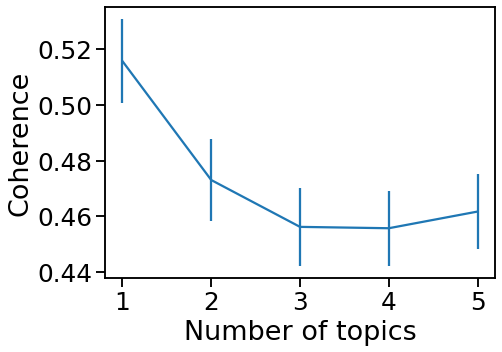

<Figure size 432x288 with 0 Axes>

In [36]:
coherence_scores_mean_per_sampling = np.mean(coherence_scores,axis=1)

coherence_scores_mean_per_sampling_per_num_topics = np.mean(coherence_scores_mean_per_sampling,axis=0)
coherence_scores_std_dev_per_sampling_per_num_topics = np.std(coherence_scores_mean_per_sampling,axis=0)

print(coherence_scores_mean_per_sampling.shape)
print(coherence_scores_mean_per_sampling_per_num_topics.shape)

plt.figure(figsize=(7,5));
plt.errorbar(num_lda_topics,coherence_scores_mean_per_sampling_per_num_topics,yerr=coherence_scores_std_dev_per_sampling_per_num_topics);
plt.ylabel('Coherence');
plt.xlabel('Number of topics')
sns.set_context('talk', font_scale=1.5);
# plt.xticks(rotation=90);
plt.show();
plt.clf();

(1000, 5)
(5,)


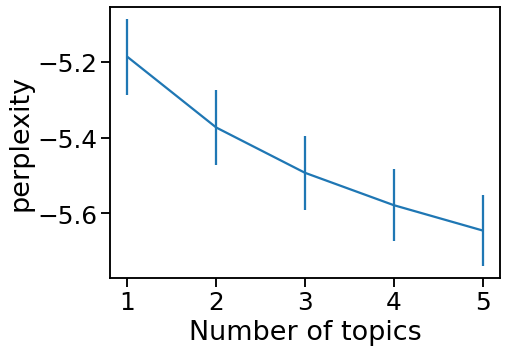

<Figure size 432x288 with 0 Axes>

In [34]:
perplexity_scores_mean_per_sampling = np.mean(perplexity_scores,axis=1)

perplexity_scores_mean_per_sampling_per_num_topics = np.mean(perplexity_scores_mean_per_sampling,axis=0)
perplexity_scores_std_dev_per_sampling_per_num_topics = np.std(perplexity_scores_mean_per_sampling,axis=0)

print(perplexity_scores_mean_per_sampling.shape)
print(perplexity_scores_mean_per_sampling_per_num_topics.shape)

plt.figure(figsize=(7,5));
# plt.plot(num_lda_topics,perplexity_scores_mean_per_sampling_per_num_topics);
plt.errorbar(num_lda_topics,perplexity_scores_mean_per_sampling_per_num_topics,yerr=perplexity_scores_std_dev_per_sampling_per_num_topics);
plt.ylabel('Perplexity');
plt.xlabel('Number of topics')
sns.set_context('talk', font_scale=1.5);
# plt.xticks(rotation=90);
plt.show();
plt.clf();

In [ ]:
# plotting for perplexity and coherence scores

# get means per bootstrap sampling
coherence_scores_mean_per_sampling = np.mean(coherence_scores,axis=1)
perplexity_scores_mean_per_sampling = np.mean(perplexity_scores,axis=1)

# get mean across bootstrap



(1000, 50, 10)
(50, 10)
(10,)
[0.03540826 0.02502673 0.02031532 0.01767512 0.0159043  0.01464067
 0.01370872        nan        nan        nan]


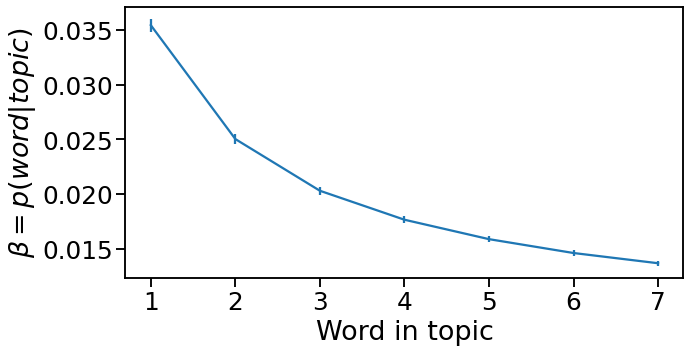

<Figure size 432x288 with 0 Axes>

In [128]:
# plotting for probability vs words, when single topics used
print(topic_word_probs.shape)

topic_word_probs_mean_samples = np.mean(topic_word_probs,axis=0)
print(topic_word_probs_mean_samples.shape)

topic_word_probs_mean_samples_articles = np.mean(topic_word_probs_mean_samples,axis=0)
topic_word_probs_std_samples_articles = np.std(topic_word_probs_mean_samples,axis=0)
print(topic_word_probs_mean_samples_articles.shape)
print(topic_word_probs_mean_samples_articles)

plt.figure(figsize=(10,5));
# plt.plot(num_lda_topics,perplexity_scores_mean_per_sampling_per_num_topics);
plt.errorbar(np.arange(1,topic_word_probs_mean_samples_articles.shape[0]+1),topic_word_probs_mean_samples_articles,yerr=topic_word_probs_std_samples_articles);
plt.ylabel(r'$\beta = p(word | topic)$');
plt.xlabel('Word in topic')
sns.set_context('talk', font_scale=1.5);
# plt.xticks(rotation=90);
plt.show();
plt.clf();

(1000, 50, 5)
(1000, 5)
(1000,)


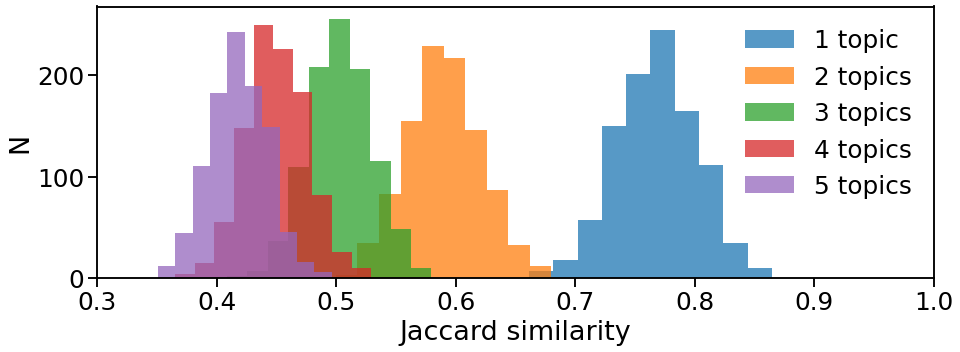

<Figure size 432x288 with 0 Axes>

In [160]:
# jaccard sim analysis

print(jaccard_sim_all.shape)

jaccard_sim_mean_per_sampling = np.mean(jaccard_sim_all,axis=1)
print(jaccard_sim_mean_per_sampling.shape)

jaccard_sim_mean_1_topic = jaccard_sim_mean_per_sampling[:,0]
jaccard_sim_mean_2_topic = jaccard_sim_mean_per_sampling[:,1]
jaccard_sim_mean_3_topic = jaccard_sim_mean_per_sampling[:,2]
jaccard_sim_mean_4_topic = jaccard_sim_mean_per_sampling[:,3]
jaccard_sim_mean_5_topic = jaccard_sim_mean_per_sampling[:,4]

print(jaccard_sim_mean_1_topic.shape)

plt.figure(figsize=(15,5));
plt.hist(jaccard_sim_mean_1_topic,alpha=0.75);
plt.hist(jaccard_sim_mean_2_topic,alpha=0.75);
plt.hist(jaccard_sim_mean_3_topic,alpha=0.75);
plt.hist(jaccard_sim_mean_4_topic,alpha=0.75);
plt.hist(jaccard_sim_mean_5_topic,alpha=0.75);
plt.ylabel('N');
plt.xlabel('Jaccard similarity')
plt.legend(('1 topic','2 topics','3 topics','4 topics','5 topics'),framealpha=0)
sns.set_context('talk', font_scale=1.5);
plt.xlim([0.3,1])
# plt.xticks(rotation=90);
plt.show();
plt.clf();

(1000, 50, 5)
(1000, 5)
(5,)


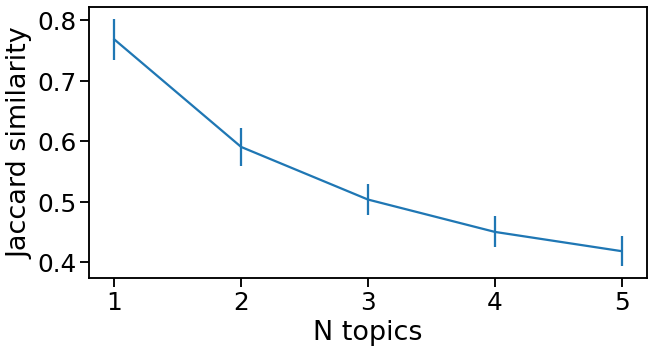

<Figure size 432x288 with 0 Axes>

In [82]:
print(jaccard_sim_all.shape)

jaccard_sim_mean_per_sampling = np.mean(jaccard_sim_all,axis=1)
print(jaccard_sim_mean_per_sampling.shape)

jaccard_sim_mean_per_sampling_per_topic = np.mean(jaccard_sim_mean_per_sampling,axis=0)
jaccard_sim_std_per_sampling_per_topic = np.std(jaccard_sim_mean_per_sampling,axis=0)

print(jaccard_sim_mean_per_sampling_per_topic.shape)

plt.figure(figsize=(10,5));
plt.errorbar(num_lda_topics,jaccard_sim_mean_per_sampling_per_topic,yerr = jaccard_sim_std_per_sampling_per_topic);
plt.ylabel('Jaccard similarity');
plt.xlabel('N topics')
sns.set_context('talk', font_scale=1.5);
# plt.xticks(rotation=90);
plt.show();
plt.clf();

(1000, 50, 5)
(1000, 5)
(1000,)


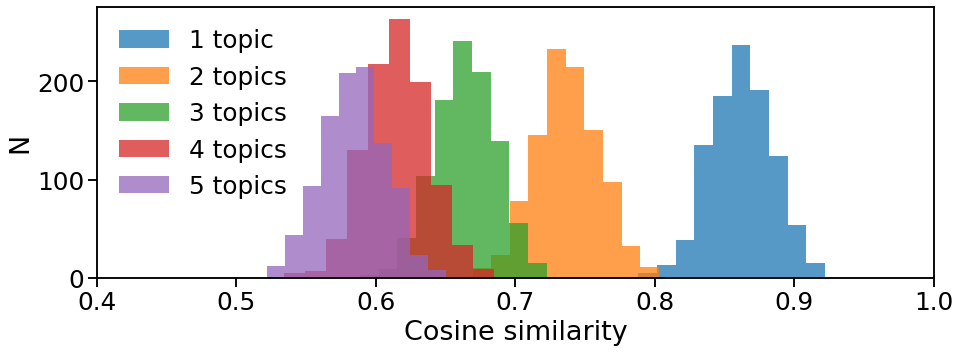

<Figure size 432x288 with 0 Axes>

In [163]:
# cosine sim analysis

print(cosine_sim_all.shape)

cosine_sim_mean_per_sampling = np.mean(cosine_sim_all,axis=1)
print(cosine_sim_mean_per_sampling.shape)

cosine_sim_mean_1_topic = cosine_sim_mean_per_sampling[:,0]
cosine_sim_mean_2_topic = cosine_sim_mean_per_sampling[:,1]
cosine_sim_mean_3_topic = cosine_sim_mean_per_sampling[:,2]
cosine_sim_mean_4_topic = cosine_sim_mean_per_sampling[:,3]
cosine_sim_mean_5_topic = cosine_sim_mean_per_sampling[:,4]

print(cosine_sim_mean_1_topic.shape)

plt.figure(figsize=(15,5));
plt.hist(cosine_sim_mean_1_topic,alpha=0.75);
plt.hist(cosine_sim_mean_2_topic,alpha=0.75);
plt.hist(cosine_sim_mean_3_topic,alpha=0.75);
plt.hist(cosine_sim_mean_4_topic,alpha=0.75);
plt.hist(cosine_sim_mean_5_topic,alpha=0.75);
plt.ylabel('N');
plt.xlabel('Cosine similarity')
plt.legend(('1 topic','2 topics','3 topics','4 topics','5 topics'),framealpha=0)
sns.set_context('talk', font_scale=1.5);
plt.xlim([0.4,1])
# plt.xticks(rotation=90);
plt.show();
plt.clf();

In [140]:
nwords_shape = number_most_common_words.shape
print(nwords_shape)
number_most_common_words_lin = number_most_common_words.reshape((nwords_shape[0]*nwords_shape[1],1))
print(number_most_common_words_lin.shape)

(1000, 50)
[[12.]
 [ 5.]
 [ 6.]
 ...
 [10.]
 [12.]
 [ 6.]]
(50000, 1)


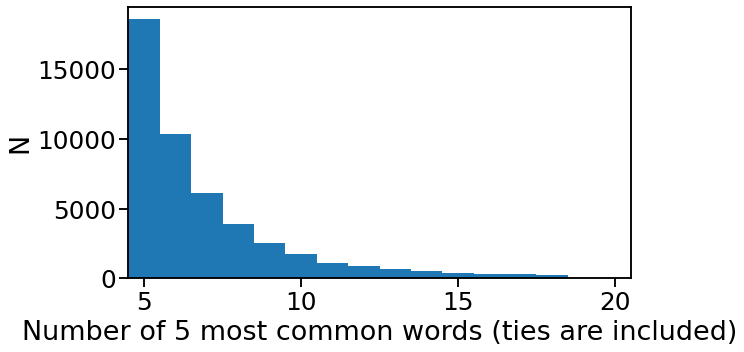

<Figure size 432x288 with 0 Axes>

In [156]:
plt.figure(figsize=(9,5));
plt.hist(number_most_common_words_lin,bins=np.arange(5,20)-.5);
plt.ylabel('N');
plt.xlabel('Number of 5 most common words (ties are included)')
sns.set_context('talk', font_scale=1.5);
# plt.xticks(rotation=90);
plt.xlim([4.5,20.5])
plt.show();
plt.clf();